# **Machine Learning Project - Sentiment Classification of Twitter Post**


## Workflow Overview
This project focuses on predicting the sentiment (positive/negative) of social media posts using machine learning techniques. The classification is based on text content, user metadata, and engagement metrics.*italicized text*

1. **Data Collection & Sensing**  
   Collected static data from posts: text, user info, likes, shares.

2. **Exploratory Data Analysis**  
   Explored distributions and correlations to uncover sentiment-related patterns.

3. **Preprocessing**  
   Cleaned missing values, encoded categorical variables, and generated new features.

4. **Feature Extraction**  
   Extracted semantic and syntactic features using TF-IDF and N-grams.

5. **Feature Selection**  
   Selected top 25 features using Fisher Score to reduce dimensionality and overfitting.

6. **Validation**  
   Applied 10-fold cross-validation with strict separation to avoid data leakage.

7. **Model Training**  
   Trained models: Decision Tree, SVM, and MLP; tuned hyperparameters via RandomizedSearchCV.

8. **Evaluation**  
   Analyzed confusion matrices, ROC curves, and feature importance for each model.

9. **Improvements**  
   Suggested enhancements in feature design and user profiling to boost performance.

10. **Final Prediction**  
    Predicted sentiment on a hold-out test set with a full pipeline.

---



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import numpy as np
from nltk.corpus import stopwords
from datetime import datetime
from collections import Counter
import pytz
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from datetime import timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from time import time
from tabulate import tabulate
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import joblib


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files
uploaded = files.upload()

Data = pd.read_csv('sentiment.csv')

Saving sentiment.csv to sentiment.csv


##Exploratory Data Analysis

Mean Likes: 349.9103102697778, Median Likes: 85.0, Standard Deviation of Likes: 1304.6288569883397
Max Likes: 29508.0, Min Likes: 20.0


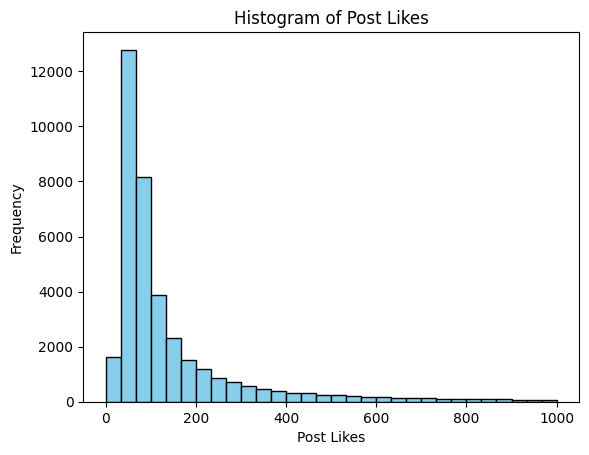

In [ ]:
#creating hisogram for number of post likes
filtered_post_likes = Data.query("post_likes != '?'").copy() # taking care of cells with missing values
filtered_post_likes['post_likes'] = pd.to_numeric(filtered_post_likes['post_likes'])
filtered_post_likes['post_likes'].plot.hist(bins=30, range =(0,1000),color='skyblue', edgecolor='black');
plt.title('Histogram of Post Likes')
plt.xlabel('Post Likes')
plt.ylabel('Frequency')

mean_likes = filtered_post_likes['post_likes'].mean()
median_likes = filtered_post_likes['post_likes'].median()
sd_likes = filtered_post_likes['post_likes'].std()
max_likes = filtered_post_likes['post_likes'].max()
min_likes = filtered_post_likes['post_likes'].min()

print(f'Mean Likes: {mean_likes}, Median Likes: {median_likes}, Standard Deviation of Likes: {sd_likes}')
print(f'Max Likes: {max_likes}, Min Likes: {min_likes}')


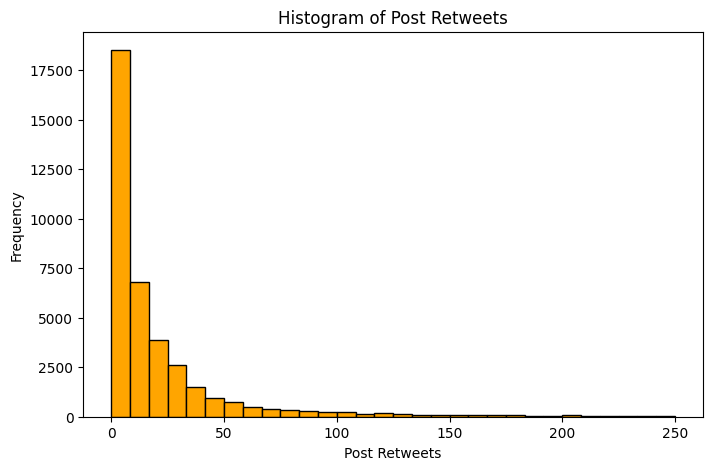

Mean Retweets: 48.69076782912386, Median Retweets: 10.0, Standard Deviation of Retweets: 276.91400825401126


In [ ]:
#creating hisogram for number of post retweets
filtered_post_retweets = Data.query("posts_retweets != '?'").copy()
filtered_post_retweets['posts_retweets'] = pd.to_numeric(filtered_post_retweets['posts_retweets'])
plt.figure(figsize=(8, 5))
filtered_post_retweets['posts_retweets'].plot.hist(bins=30,range=(0, 250),  color='orange', edgecolor='black')
plt.title('Histogram of Post Retweets')
plt.xlabel('Post Retweets')
plt.ylabel('Frequency')
plt.show()

mean_retweets = filtered_post_retweets['posts_retweets'].mean()
median_retweets = filtered_post_retweets['posts_retweets'].median()
sd_retweets = filtered_post_retweets['posts_retweets'].std()
print(f'Mean Retweets: {mean_retweets}, Median Retweets: {median_retweets}, Standard Deviation of Retweets: {sd_retweets}')

Mean Followers: 487.6668775303644, Median Followers: 103.0, Standard Deviation of Followers: 2611.4301299193403, max followers: 120692.0, min followers: 0.0


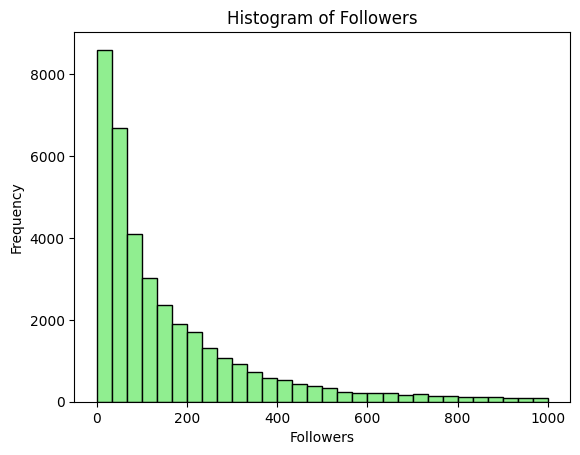

In [ ]:
#creating hisogram for number of user followers
filtered_followers = Data.query("followers != '?'").copy() # taking care of cells with missing values
filtered_followers['followers'] = pd.to_numeric(filtered_followers['followers'])
filtered_followers['followers'].plot.hist(bins=30, range =(0,1000),color='lightgreen', edgecolor='black');
plt.title('Histogram of Followers')
plt.xlabel('Followers')
plt.ylabel('Frequency')

mean_followers = filtered_followers['followers'].mean()
median_followers = filtered_followers['followers'].median()
sd_followers = filtered_followers['followers'].std()
max_followers = filtered_followers['followers'].max()
min_followers = filtered_followers['followers'].min()

print(f'Mean Followers: {mean_followers}, Median Followers: {median_followers}, '
      f'Standard Deviation of Followers: {sd_followers}, max followers: {max_followers}, '
      f'min followers: {min_followers}')

Mean Previous Posts: 105.17239372469636, Median Previous Posts: 82.0, Standard Deviation of Previous Posts: 87.12136216960857, Min Previous Posts: 0, Max Previous Posts: 679


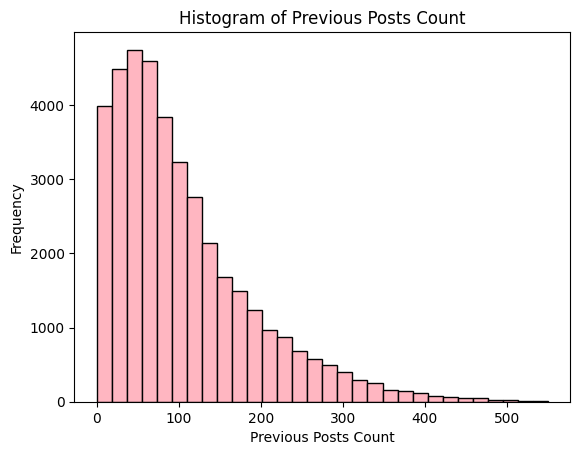

In [ ]:
#creating hisogram for number of previous posts
filtered_previous_posts = Data.query("previous_posts_count != '?'").copy() # taking care of cells with missing values
filtered_previous_posts['previous_posts_count'] = pd.to_numeric(filtered_previous_posts['previous_posts_count'])
filtered_previous_posts['previous_posts_count'].plot.hist(bins=30,range =(0,550), color='lightpink', edgecolor='black');
plt.title('Histogram of Previous Posts Count')
plt.xlabel('Previous Posts Count')
plt.ylabel('Frequency')

mean_previous_posts = filtered_previous_posts['previous_posts_count'].mean()
median_previous_posts = filtered_previous_posts['previous_posts_count'].median()
max_previous_posts = filtered_previous_posts['previous_posts_count'].max()
min_previous_posts = filtered_previous_posts['previous_posts_count'].min()
sd_previous_posts = filtered_previous_posts['previous_posts_count'].std()
print(f'Mean Previous Posts: {mean_previous_posts}, Median Previous Posts: {median_previous_posts}, Standard Deviation of Previous Posts: {sd_previous_posts}, Min Previous Posts: {min_previous_posts}, Max Previous Posts: {max_previous_posts}')

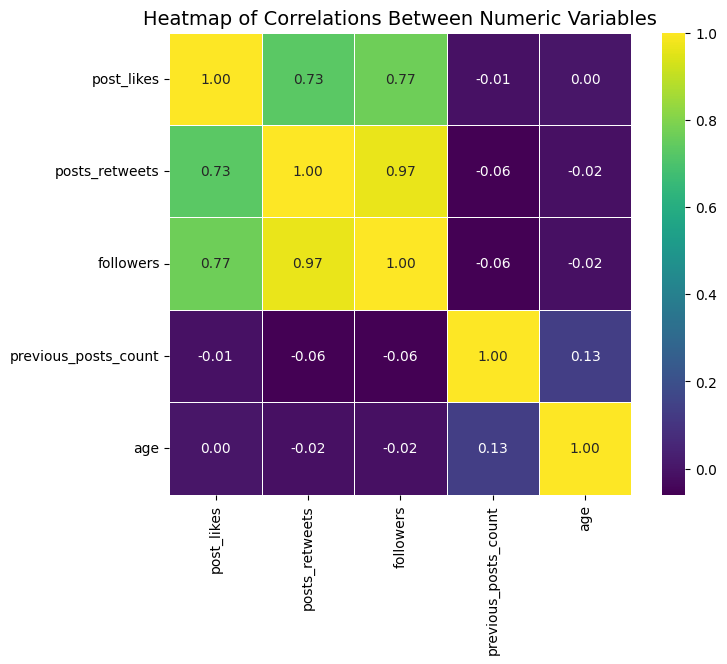

In [ ]:
# Create a heatmap of correlations between numeric variables
Data['birthday'] = pd.to_datetime(Data['birthday'], errors='coerce')
today = pd.to_datetime("today")
Data['age'] = (today - Data['birthday']).dt.days // 365  # floor division to get full years

cols_to_convert = ['followers', 'previous_posts_count', 'post_likes', 'posts_retweets', 'age']
for col in cols_to_convert:
    Data[col] = pd.to_numeric(Data[col], errors='coerce').copy()

# Select numeric columns and compute correlation matrix
numeric_data = Data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", square=True, linewidths=0.5)
plt.title('Heatmap of Correlations Between Numeric Variables', fontsize=14)
plt.show()

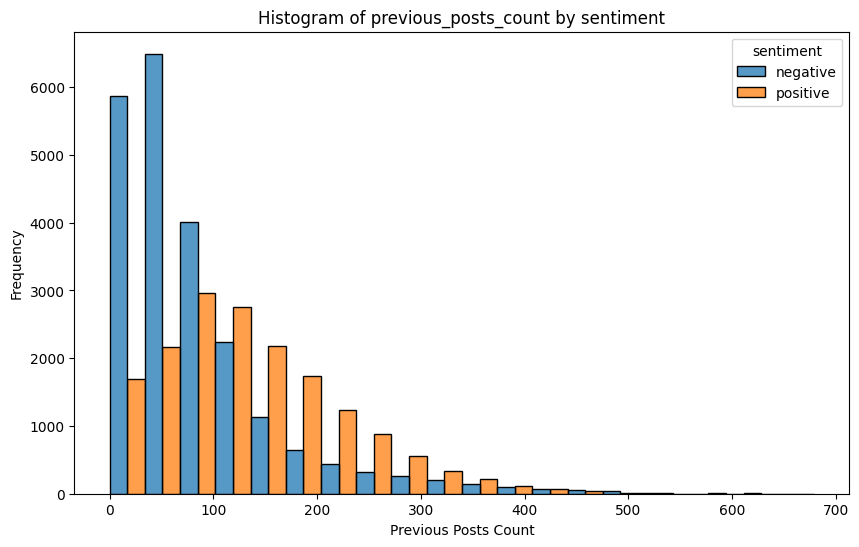

Mean Previous Posts Count for Positive Sentiment: 135.7293410350112, Mean Previous Posts Count for Negative Sentiment: 81.57157125346166


In [ ]:
# Create a histogram of previous_posts_count by sentiment with adjacent bars
df_copy_clean = Data.query("sentiment != '?' and previous_posts_count != '?'").copy()
df_copy_clean['previous_posts_count'] = pd.to_numeric(df_copy_clean['previous_posts_count'])
plt.figure(figsize=(10, 6))
sns.histplot(data=df_copy_clean, x='previous_posts_count', hue='sentiment', multiple='dodge', kde=False, bins=20)
plt.title('Histogram of previous_posts_count by sentiment')
plt.xlabel('Previous Posts Count')
plt.ylabel('Frequency')
plt.show()

mean_previous_posts_positive = df_copy_clean[df_copy_clean['sentiment'] == 'positive']['previous_posts_count'].mean()
mean_previous_posts_negative = df_copy_clean[df_copy_clean['sentiment'] == 'negative']['previous_posts_count'].mean()
print(f'Mean Previous Posts Count for Positive Sentiment: {mean_previous_posts_positive}, Mean Previous Posts Count for Negative Sentiment: {mean_previous_posts_negative}')

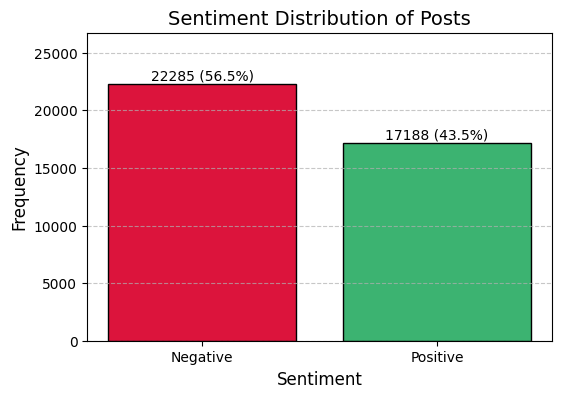

In [ ]:
# Map sentiment to numerical values
sentiment_mapping = {
    'negative': -1,
    'positive': 1
}
filtered_previous_posts = Data.query("sentiment != '?'").copy()
filtered_previous_posts['sentiment'] = filtered_previous_posts['sentiment'].map(sentiment_mapping)

# Count the frequency of each sentiment
sentiment_counts = filtered_previous_posts['sentiment'].value_counts().sort_index()
total_posts = sentiment_counts.sum()

# Map numeric values back to readable labels for the x-axis
sentiment_labels = {-1: 'Negative', 1: 'Positive'}
sentiment_counts.index = sentiment_counts.index.map(sentiment_labels)

# Plot a bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=['crimson', 'mediumseagreen'], edgecolor='black')

# Add value and percentage labels on top of bars
for bar, label in zip(bars, sentiment_counts.index):
    height = bar.get_height()
    percentage = height / total_posts * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 100,
        f"{height} ({percentage:.1f}%)",
        ha='center',
        va='bottom',
        fontsize=10
    )

# Styling the plot
plt.title(f'Sentiment Distribution of Posts', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.ylim(0, sentiment_counts.max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)


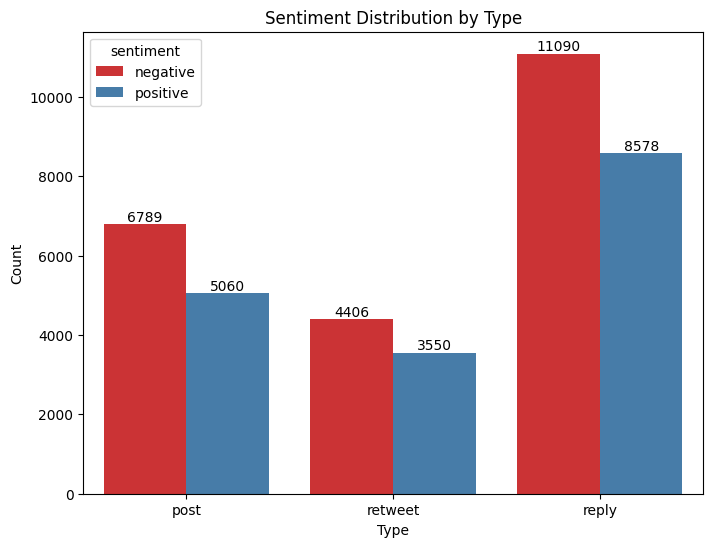

In [ ]:
# Create a countplot of sentiment distribution by type
filtered_type = Data.query("sentiment != '?'").copy()
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=filtered_type, x='type', hue='sentiment', palette='Set1')
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)
plt.title("Sentiment Distribution by Type")
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

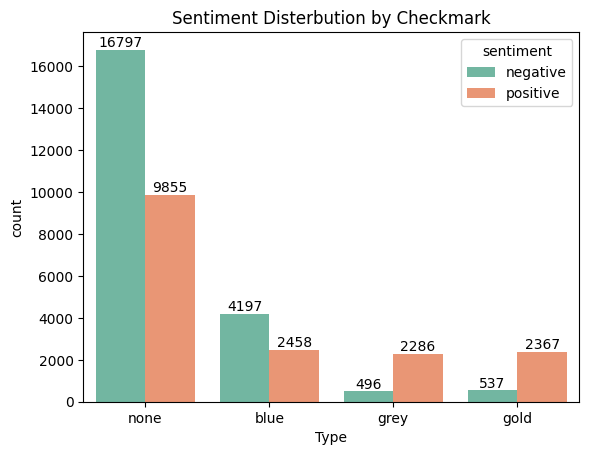

In [ ]:
# Create a countplot of sentiment distribution by checkmark
filtered_data = Data[
    (Data['sentiment'].str.strip() != '?') &
    (Data['checkmark'].str.strip() != '?')
].copy()
ax = sns.countplot(data = filtered_data, x='checkmark', hue='sentiment', palette='Set2')
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=10)
plt.title("Sentiment Disterbution by Checkmark")
plt.xlabel('Type')
plt.show()

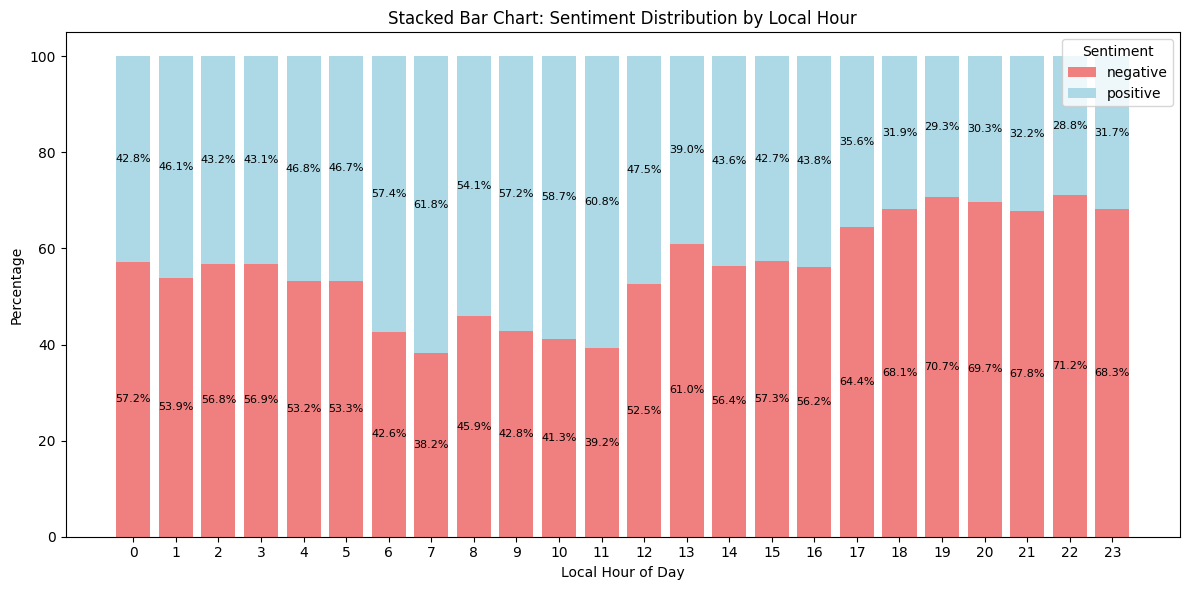

In [ ]:
#local hour post time analysis
timezone_map = {
    'UTC': 0,
    'GMT': 0,
    'CET': 1,
    'EET': 2,
    'MSK': 3,
    'PST': -8,
    'EST': -5,
    'AEST': 10,
    'JST': 9,
    'KST': 9
}
post_time = pd.to_datetime(Data['post_datetime'], errors='coerce')
timezone_offset = Data['timezone'].map(timezone_map)
valid_rows = (
    post_time.notna() &
    timezone_offset.notna() &
    Data['sentiment'].isin(['positive', 'negative'])
)
local_post_time = post_time[valid_rows] + pd.to_timedelta(timezone_offset[valid_rows], unit='h')
local_hour = local_post_time.dt.hour
temp_df = pd.DataFrame({
    'hour': local_hour,
    'sentiment': Data.loc[valid_rows, 'sentiment']
})

grouped = temp_df.groupby(['hour', 'sentiment']).size().unstack(fill_value=0)
percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100
plt.figure(figsize=(12, 6))
bottom = None
colors = {'positive': '#ADD8E6', 'negative': '#F08080'}

for sentiment in percentages.columns:
    plt.bar(percentages.index, percentages[sentiment], bottom=bottom, label=sentiment, color=colors.get(sentiment))
    bottom = percentages[sentiment] if bottom is None else bottom + percentages[sentiment]

for hour in percentages.index:
    y_offset = 0
    for sentiment in percentages.columns:
        percent = percentages.loc[hour, sentiment]
        if percent > 3:
            plt.text(hour, y_offset + percent / 2, f'{percent:.1f}%', ha='center', va='center', fontsize=8)
        y_offset += percent

plt.title('Stacked Bar Chart: Sentiment Distribution by Local Hour')
plt.xlabel('Local Hour of Day')
plt.ylabel('Percentage')
plt.xticks(range(24))
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

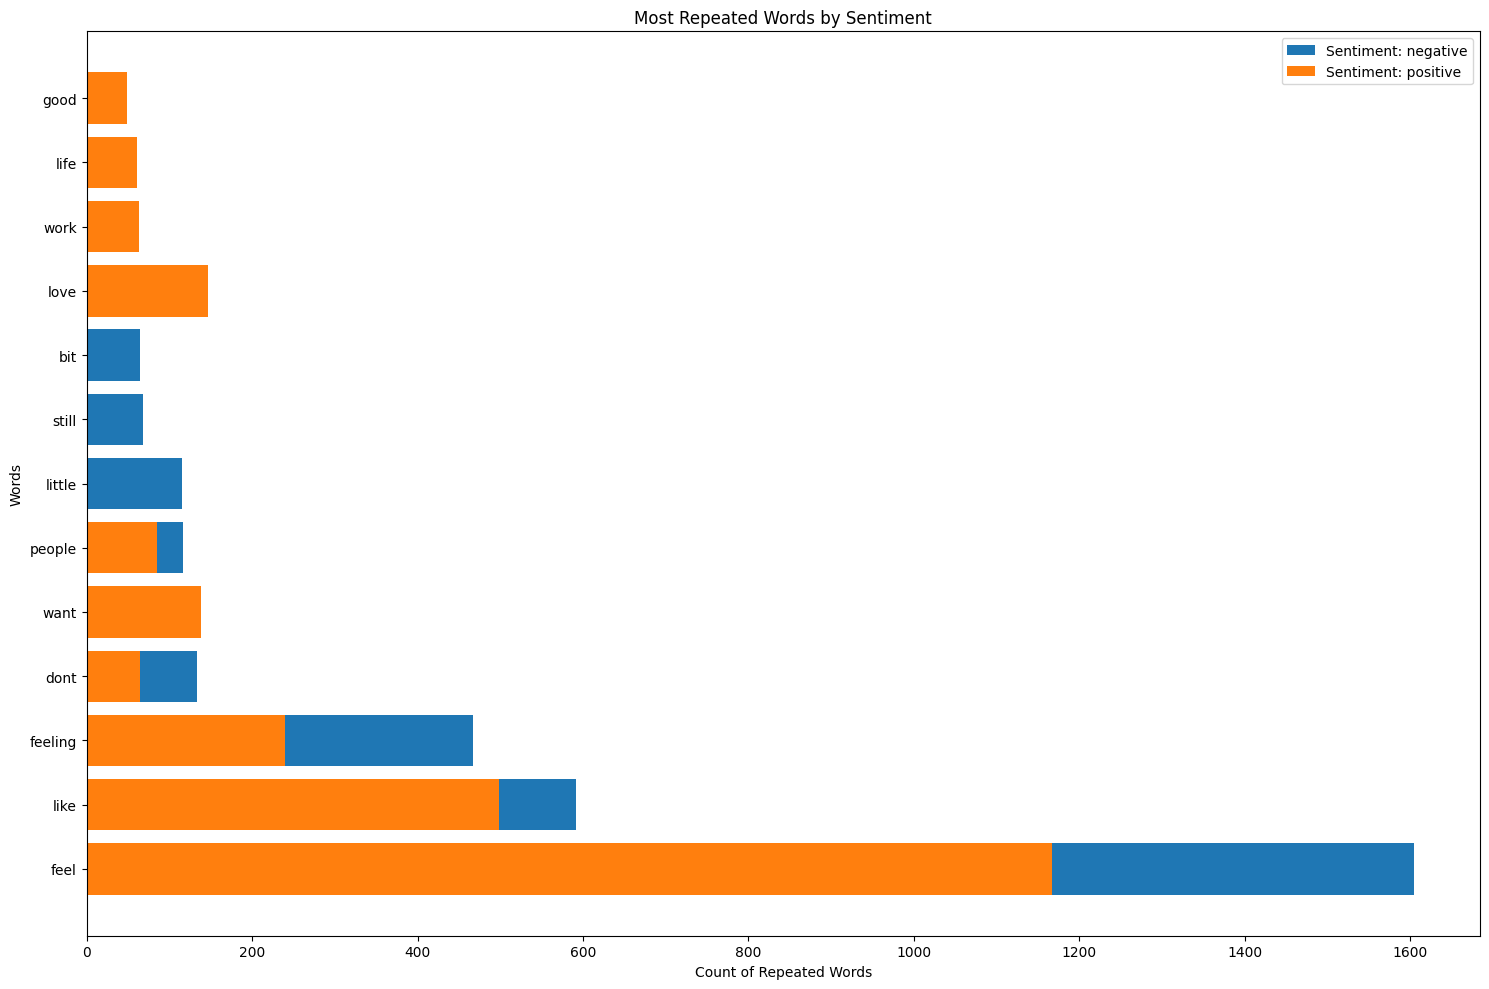

In [ ]:
# text analysing

# additional stop words
additional_stops = {
    'just', 'really', 'very', 'im', 'ive', 'get', 'got', 'getting', 'would', 'could', 'one',
    'thing', 'things', 'something', 'someone', 'also', 'even', 'much', 'way', 'time', 'lot',
    'go', 'going', 'goes', 'went', 'gone', 'make', 'makes', 'making', 'made', 'see', 'seeing',
    'saw', 'seen', 'know', 'knowing', 'knew', 'known', 'think', 'thinking', 'thought',
    'come', 'coming', 'came', 'take', 'taking', 'took', 'taken', 'day', 'now', 'today',
    'lol', 'idk', 'tbh', 'imo', 'rn', 'omg', 'btw', 'lmao'
}

# extracting words not in stop words
def extract_words(text):
    words = text.split()
    stop_words = set(stopwords.words('english'))
    stop_words.update(additional_stops)
    return [word.lower() for word in words if word.lower() not in stop_words]

# counting repeated words
def count_word_repeats(words):
    word_counts = Counter(words)
    return {word: count for word, count in word_counts.items() if count > 1}

# columns processing
Data['words'] = Data['text'].apply(extract_words)
Data['repeated_words'] = Data['words'].apply(count_word_repeats)

Data = Data[Data['sentiment'] != '?']
sentiments = Data['sentiment'].unique()
plt.figure(figsize=(15, 10))

for sentiment in sentiments:
    sentiment_df = Data[Data['sentiment'] == sentiment]
    all_repeated_words = Counter()

    for repeated in sentiment_df['repeated_words']:
        all_repeated_words.update(repeated)

    most_common_words = all_repeated_words.most_common(10)

    if most_common_words:
        words, counts = zip(*most_common_words)
        plt.barh(words, counts, label=f'Sentiment: {sentiment}')
    else:
        print(f"No repeated words found for sentiment: {sentiment}")

plt.title('Most Repeated Words by Sentiment')
plt.xlabel('Count of Repeated Words')
plt.ylabel('Words')
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-15-1219579123.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Sentiment')


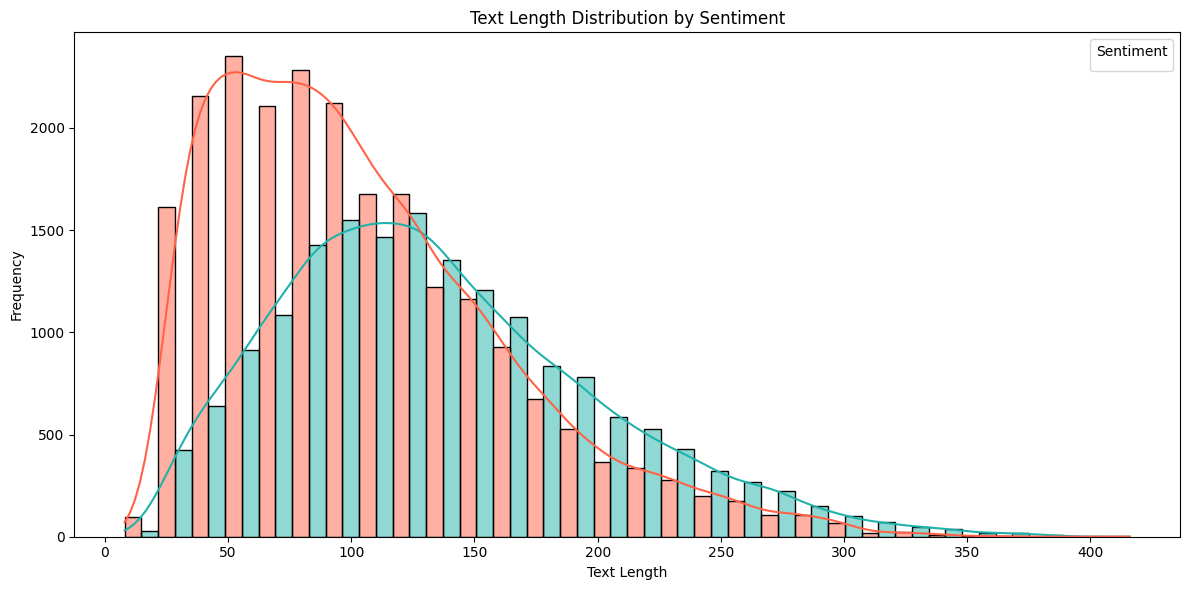

In [ ]:
#text length analysing
filtered_data = Data[Data['text'].str.strip() != '?'].copy()
filtered_data = filtered_data[filtered_data['sentiment'] != '?'].copy()
filtered_data['text_length'] = filtered_data['text'].str.len()
plt.figure(figsize=(12, 6))
sns.histplot(data=filtered_data, x='text_length', hue='sentiment', multiple='dodge', kde=True, bins=30, palette={'positive': 'lightseagreen', 'negative': 'tomato'})
plt.title("Text Length Distribution by Sentiment")
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(title='Sentiment')
plt.tight_layout()

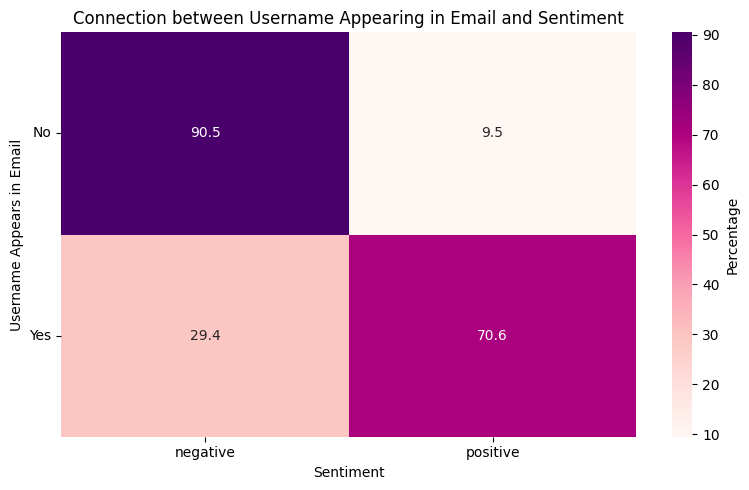

In [ ]:

df = Data[Data['sentiment'] != '?'].copy()

# creating the column for checking if there is a sequence of at least 3 characters
df['username_in_email'] = df.apply(
    lambda row: any(row['username'][i:i+3] in row['email']
                    for i in range(len(row['username']) - 2))
                if pd.notna(row['username']) and pd.notna(row['email']) else False,
    axis=1
)

# table: username_in_email × sentiment
pivot = pd.crosstab(
    df['username_in_email'],
    df['sentiment'],
    normalize='index'
).reindex(columns=['negative', 'positive'], fill_value=0) * 100

# heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap='RdPu', cbar_kws={'label': 'Percentage'})
plt.title("Connection between Username Appearing in Email and Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Username Appears in Email")
plt.yticks([0.5, 1.5], ['No', 'Yes'], rotation=0)
plt.tight_layout()
plt.show()

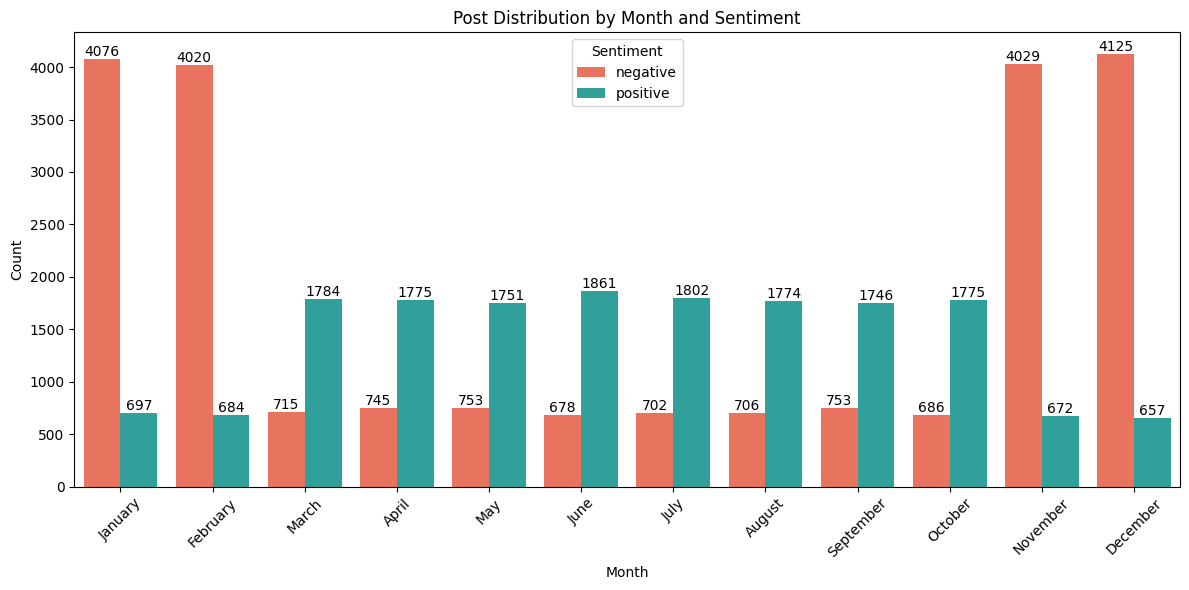

In [ ]:
# Create a distribution plot of posts by month with sentiment breakdown
filtered_data = Data[(Data['post_datetime'].str.strip() != '?') & (Data['sentiment'] != '?')].copy()
filtered_data['post_datetime'] = pd.to_datetime(filtered_data['post_datetime'], errors='coerce')
filtered_data = filtered_data.dropna(subset=['post_datetime'])

# Extract month and create month name for better readability
filtered_data['post_month'] = filtered_data['post_datetime'].dt.month
filtered_data['month_name'] = filtered_data['post_datetime'].dt.strftime('%B')  # Month name

# Create order list for months to display in chronological order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=filtered_data, x='month_name', hue='sentiment',
                  order=month_order, palette={'positive': 'lightseagreen', 'negative': 'tomato'})

# Add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.title("Post Distribution by Month and Sentiment")
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

/tmp/ipython-input-18-3306783880.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_sentiment_counts = df_filtered.groupby(["age_group", "sentiment"]).size().reset_index(name="count")
/tmp/ipython-input-18-3306783880.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_sentiment_counts["total_count"] = age_sentiment_counts.groupby("age_group")["count"].transform("sum")


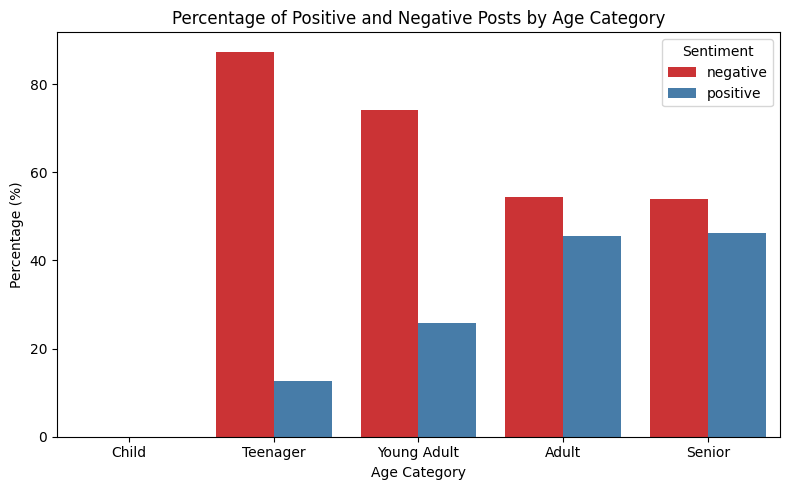

In [ ]:
#age group analysing

Data["birthday"] = pd.to_datetime(Data["birthday"], errors="coerce")
current_year = datetime.now().year
Data["age"] = current_year - Data["birthday"].dt.year

# Filter valid ages and sentiments
df_filtered = Data[Data["sentiment"].isin(["positive", "negative"])]
df_filtered = df_filtered[(df_filtered["age"] >= 0) & (df_filtered["age"] <= 120)]

# Define new age bins and labels
bins = [0, 13, 18, 25, 65, float("inf")]
labels = ["Child", "Teenager", "Young Adult", "Adult", "Senior"]

# Create age_group column
df_filtered["age_group"] = pd.cut(df_filtered["age"], bins=bins, labels=labels, right=False)

# Count posts by age group and sentiment
age_sentiment_counts = df_filtered.groupby(["age_group", "sentiment"]).size().reset_index(name="count")
age_sentiment_counts["total_count"] = age_sentiment_counts.groupby("age_group")["count"].transform("sum")
age_sentiment_counts["percentage"] = (age_sentiment_counts["count"] / age_sentiment_counts["total_count"]) * 100

# Plot the results
plt.figure(figsize=(8, 5))
sns.barplot(data=age_sentiment_counts, x="age_group", y="percentage", hue="sentiment", palette="Set1")
plt.title("Percentage of Positive and Negative Posts by Age Category")
plt.xlabel("Age Category")
plt.ylabel("Percentage (%)")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

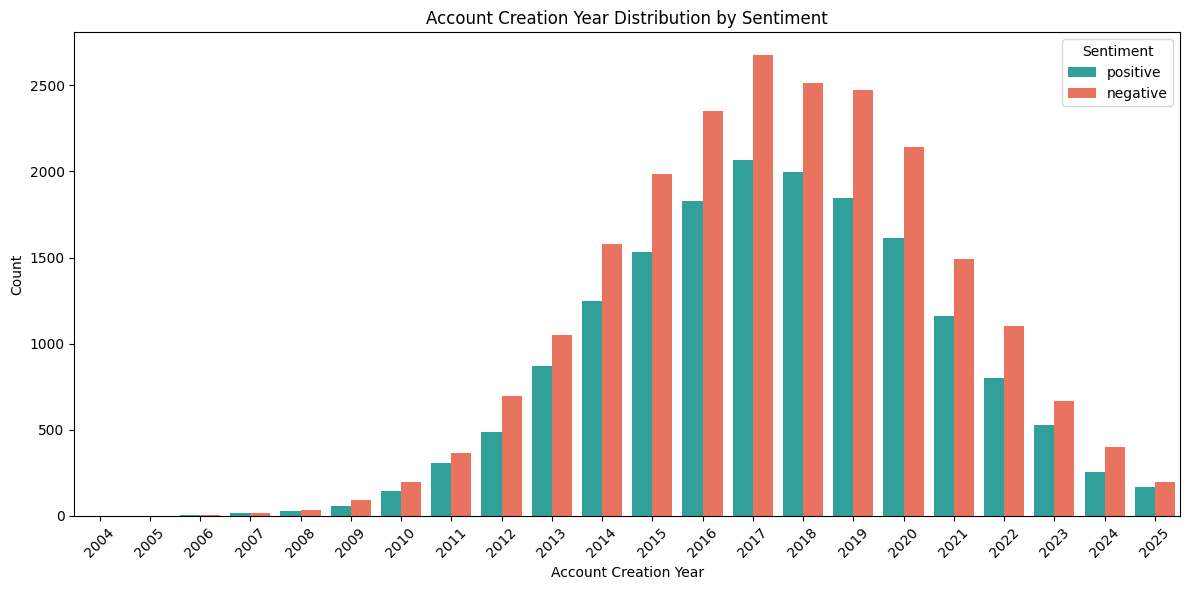

Mean Account Creation Year for Positive Sentiment: 2017.417658847106, Mean Account Creation Year for Negative Sentiment: 2017.4603895219504
SD Account Creation Year for Positive Sentiment: 3.1987551864234014, SD Account Creation Year for Negative Sentiment: 3.2078217384866448


In [ ]:
#acount creation year analysing
filtered_data = Data[Data['account_creation_date'].str.strip() != '?'].copy()
filtered_data = filtered_data[filtered_data['sentiment'] != '?'].copy()  # Filter out any unknown sentiment values

# Convert to datetime and extract year
filtered_data['account_creation_date'] = pd.to_datetime(filtered_data['account_creation_date'], errors='coerce')
filtered_data['account_creation_year'] = filtered_data['account_creation_date'].dt.year

# Remove any rows with NaT (Not a Time) values that couldn't be parsed
filtered_data = filtered_data.dropna(subset=['account_creation_year'])

# Create the plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=filtered_data, x='account_creation_year', hue='sentiment', palette={'negative': 'tomato', 'positive': 'lightseagreen'})
plt.title("Account Creation Year Distribution by Sentiment")
plt.xlabel('Account Creation Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()  # Adjust layout to ensure everything fits
plt.show()

mean_account_creation_year_positive = filtered_data[filtered_data['sentiment'] == 'positive']['account_creation_year'].mean()
mean_account_creation_year_negative = filtered_data[filtered_data['sentiment'] == 'negative']['account_creation_year'].mean()
sd_account_creation_year_positive = filtered_data[filtered_data['sentiment'] == 'positive']['account_creation_year'].std()
sd_account_creation_year_negative = filtered_data[filtered_data['sentiment'] == 'negative']['account_creation_year'].std()
print(f'Mean Account Creation Year for Positive Sentiment: {mean_account_creation_year_positive}, Mean Account Creation Year for Negative Sentiment: {mean_account_creation_year_negative}')
print(f'SD Account Creation Year for Positive Sentiment: {sd_account_creation_year_positive}, SD Account Creation Year for Negative Sentiment: {sd_account_creation_year_negative}')

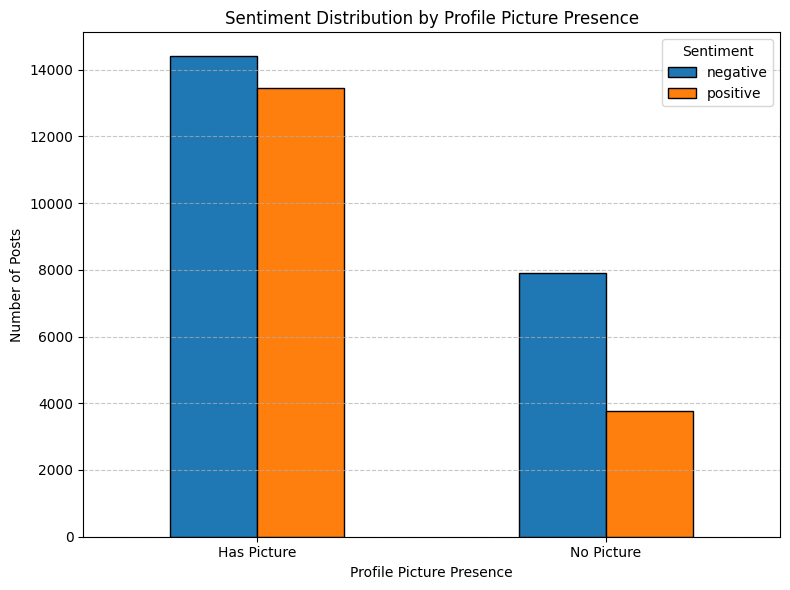

In [ ]:
#profile picture presence analysing
Data['has_profile_picture'] = Data['profile_picture'].apply(
    lambda x: 'Has Picture' if pd.notna(x) and str(x).strip() != '' else 'No Picture')
filtered = Data[Data['sentiment'].isin(['positive', 'negative'])]
crosstab = pd.crosstab(filtered['has_profile_picture'], filtered['sentiment'])
crosstab.plot(kind='bar', figsize=(8, 6), edgecolor='black')
plt.title('Sentiment Distribution by Profile Picture Presence')
plt.xlabel('Profile Picture Presence')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


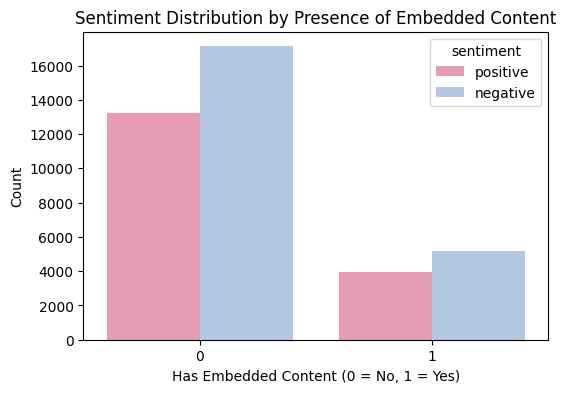

In [ ]:
# Create a countplot of sentiment distribution by presence of embedded content
Data['has_embedded_content'] = Data['embedded_content_url'].apply(lambda x: 0 if pd.isna(x) or str(x).strip() == '' else 1)
filtered_data = Data.query("sentiment != '?'").copy()
plt.figure(figsize=(6, 4))
sns.countplot(data=filtered_data, x='has_embedded_content', hue='sentiment', palette={'positive': '#F48FB1', 'negative': '#aec7e8'})
plt.title("Sentiment Distribution by Presence of Embedded Content")
plt.xlabel('Has Embedded Content (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


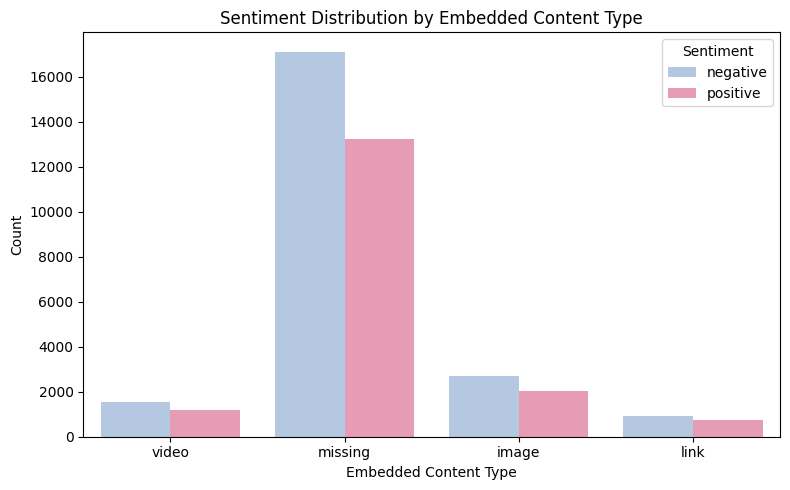

In [ ]:
# classifying embedded added file
def classify_embedded(url):
    if pd.isna(url) or str(url).strip() == '':
        return 'missing'
    url = url.lower().strip()
    last_part = url.split('/')[-1]
    if '.' in last_part:
        ext = last_part.split('.')[-1].split('?')[0].split('#')[0]
        if ext in ['jpg', 'jpeg', 'png', 'gif', 'bmp', 'webp']:
            return 'image'
        elif ext in ['mp4', 'avi', 'mov', 'wmv', 'mkv', 'webm']:
            return 'video'
        else:
            return 'other'
    return 'link'

Data['embedded_category'] = Data['embedded_content_url'].apply(classify_embedded)
filtered_data = Data.query("sentiment != '?'").copy()
plt.figure(figsize=(8, 5))
sns.countplot(data=filtered_data, x='embedded_category', hue='sentiment', palette={'positive': '#F48FB1', 'negative': '#aec7e8'})
plt.title("Sentiment Distribution by Embedded Content Type")
plt.xlabel("Embedded Content Type")
plt.ylabel("Count")
plt.legend(title='Sentiment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




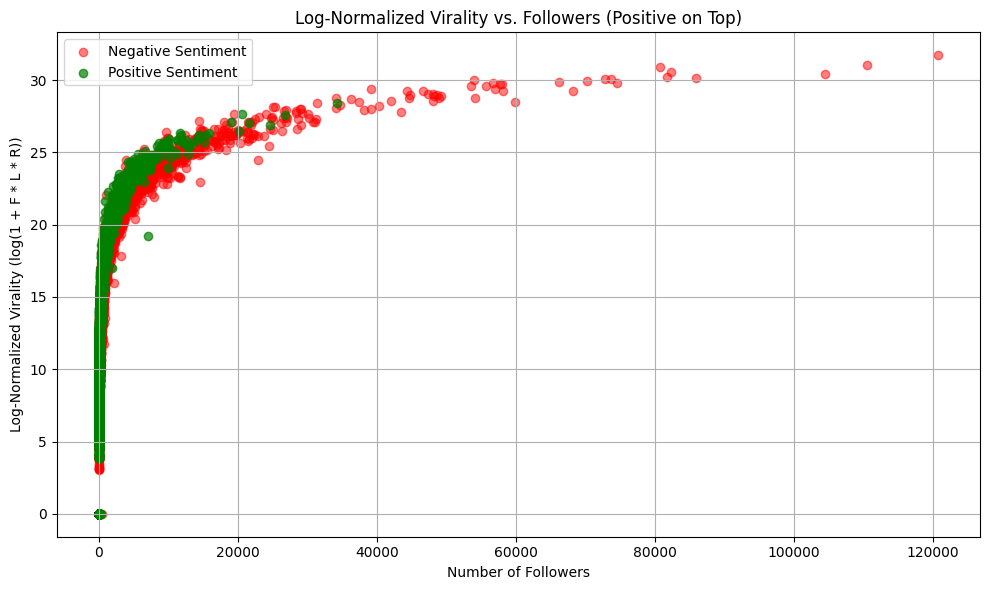

In [ ]:
#virality analysing
# Convert relevant columns to numeric
Data['followers'] = pd.to_numeric(Data['followers'], errors='coerce')
Data['post_likes'] = pd.to_numeric(Data['post_likes'], errors='coerce')
Data['posts_retweets'] = pd.to_numeric(Data['posts_retweets'], errors='coerce')

# Calculate raw virality
Data['virality'] = Data['followers'] * Data['post_likes'] * Data['posts_retweets']

# Logarithmic normalization (log(1 + x))
Data['virality_normalized'] = np.log1p(Data['virality'])

# Filter for valid (finite) values
Data_filtered = Data[np.isfinite(Data['followers']) & np.isfinite(Data['virality_normalized'])]

# Split by sentiment
positive_data = Data_filtered[Data_filtered['sentiment'] == 'positive']
negative_data = Data_filtered[Data_filtered['sentiment'] == 'negative']

# Plot
plt.figure(figsize=(10, 6))

# Plot negative sentiment first (so positives are on top)
plt.scatter(negative_data['followers'], negative_data['virality_normalized'],
            color='red', alpha=0.5, label='Negative Sentiment')

plt.scatter(positive_data['followers'], positive_data['virality_normalized'],
            color='green', alpha=0.7, label='Positive Sentiment')

# Titles and labels
plt.title('Log-Normalized Virality vs. Followers (Positive on Top)')
plt.xlabel('Number of Followers')
plt.ylabel('Log-Normalized Virality (log(1 + F * L * R))')

# Legend and layout
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

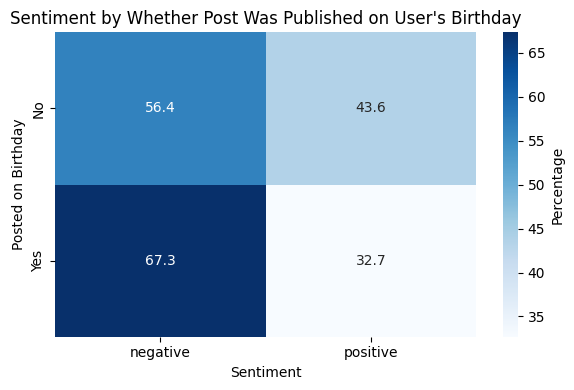

In [ ]:
#user birthday and post datetime analysing
Data['post_datetime'] = pd.to_datetime(Data['post_datetime'], errors='coerce')
Data['birthday'] = pd.to_datetime(Data['birthday'], errors='coerce')
Data['on_birthday'] = Data.apply(
    lambda row: 'Yes' if pd.notna(row['post_datetime']) and pd.notna(row['birthday']) and
                row['post_datetime'].month == row['birthday'].month and
                row['post_datetime'].day == row['birthday'].day else 'No',axis=1)
filtered = Data[Data['sentiment'].isin(['positive', 'negative'])].copy()
table = (pd.crosstab(filtered['on_birthday'], filtered['sentiment'], normalize='index') * 100).round(1)
plt.figure(figsize=(6, 4))
sns.heatmap(
    table,
    annot=True,
    cmap='Blues',
    fmt='.1f',
    cbar_kws={'label': 'Percentage'}
)
plt.title("Sentiment by Whether Post Was Published on User's Birthday")
plt.xlabel("Sentiment")
plt.ylabel("Posted on Birthday")
plt.tight_layout()
plt.show()



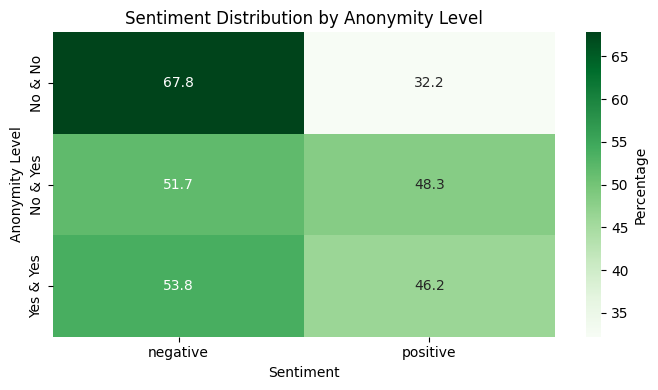

In [ ]:
#anonymity level analysis
Data['username_in_email'] = Data.apply(
    lambda row: 'Yes' if pd.notna(row['username']) and pd.notna(row['email']) and
                str(row['username']).lower() in str(row['email']).lower() else 'No',axis = 1)
Data['has_profile_picture'] = Data['profile_picture'].apply(
    lambda x: 'Yes' if pd.notna(x) and str(x).strip() != '' else 'No')
Data['anonymity_level'] = Data['username_in_email'] + ' & ' + Data['has_profile_picture']
filtered = Data[Data['sentiment'].isin(['positive', 'negative'])].copy()
table = ( pd.crosstab(filtered['anonymity_level'], filtered['sentiment'], normalize='index') * 100).round(1)
plt.figure(figsize=(7, 4))
sns.heatmap(
    table,
    annot=True,
    cmap='Greens',
    fmt='.1f',
    cbar_kws={'label': 'Percentage'}
)
plt.title('Sentiment Distribution by Anonymity Level')
plt.xlabel('Sentiment')
plt.ylabel('Anonymity Level')
plt.tight_layout()
plt.show()


##Pre Processing

In [ ]:
# Function to check for duplicate rows in the dataset
def check_duplicates(df):
    duplicated_rows = df[df.duplicated()]
    if duplicated_rows.empty:
        print("No duplicate rows found.")
    else:
        print("Duplicate rows found")
        print(duplicated_rows)


# Function to display missing values in the dataset
def remove_unnecessary_rows(filtered_data):
    rows_with_question_marks = (filtered_data == '?').sum(axis=1)
    rows_with_8_questions = (filtered_data == '?').sum(axis=1) == 8
    filtered_data = filtered_data[rows_with_question_marks < 8].copy()
    percentage_rows_with_8_questions = (rows_with_8_questions.sum() / len(filtered_data)) * 100
    print(f"\nPercentage of rows with 8 question marks: {percentage_rows_with_8_questions:.2f}%")
    return filtered_data

def display_missing_values(filtered_data):
    # Checking for missing values in each column
    missing_counts = {}
    for column in filtered_data.columns:
        missing_counts[column] = (filtered_data[column] == '?').sum()
    print(f"{'Column':<25} | {'Missing Values':>15}")
    print("-" * 45)
    for col, count in missing_counts.items():
        print(f"{col:<25} | {count:>15}")

# Function to display the percentage of missing values in each column
def display_percentages(filtered_data):
    print(f"{'Column':<25} | {'Missing Values (%)':>20}")
    print("-" * 45)
    for column in filtered_data.columns:
        if (filtered_data[column] == '?').sum() > 0:
            total_count = len(filtered_data)
            missing_count = (filtered_data[column] == '?').sum()
            percentage_missing = (missing_count / total_count) * 100
            print(f"{column:<25} | {percentage_missing:>19.2f}%")

# Function to convert data types for certain columns
def convert_data_types(filtered_data):
    filtered_data['post_datetime'] = pd.to_datetime(filtered_data['post_datetime'], errors='coerce')
    filtered_data['account_creation_date'] = pd.to_datetime(filtered_data['account_creation_date'], errors='coerce')
    filtered_data['birthday'] = pd.to_datetime(filtered_data['birthday'], errors='coerce')
    filtered_data['post_likes'] = pd.to_numeric(filtered_data['post_likes'], errors='coerce')
    filtered_data['posts_retweets'] = pd.to_numeric(filtered_data['posts_retweets'], errors='coerce')
    filtered_data['followers'] = pd.to_numeric(filtered_data['followers'], errors='coerce')

    filtered_data['text'] = filtered_data['text'].astype('string')
    filtered_data['sentiment'] = filtered_data['sentiment'].astype('string')
    filtered_data['type'] = filtered_data['type'].astype('string')
    filtered_data['timezone'] = filtered_data['timezone'].astype('string')
    filtered_data['embedded_content_url'] = filtered_data['embedded_content_url'].astype('string')
    filtered_data['username'] = filtered_data['username'].astype('string')
    filtered_data['checkmark'] = filtered_data['checkmark'].astype('string')
    filtered_data['email'] = filtered_data['email'].astype('string')
    filtered_data['profile_picture'] = filtered_data['profile_picture'].astype('string')
    filtered_data['previous_posts_count'] = pd.to_numeric(filtered_data['previous_posts_count'], errors='coerce')

    return filtered_data

def display_column_types(df):
    print(f"{'Column':<25} | {'Data Type':>15}")
    print("-" * 45)
    for column in df.columns:
        print(f"{column:<25} | {str(df[column].dtype):>15}")


''' Load data, we are loading at newly so that any change that might have accured
during the data analysis phase will not appear for the data creation phase'''

new_data = pd.read_csv('sentiment.csv')

# Check for duplicates
check_duplicates(new_data)

#removing rows with 8 missing values or more
new_data = remove_unnecessary_rows(new_data)

# Display missing values
display_missing_values(new_data)

# Display percentages of missing values
display_percentages(new_data)

new_data = convert_data_types(new_data)

No duplicate rows found.

Percentage of rows with 8 question marks: 1.21%
Column                    |  Missing Values
---------------------------------------------
id                        |               0
text                      |               0
sentiment                 |             527
type                      |               0
post_datetime             |             507
timezone                  |             507
post_likes                |             486
posts_retweets            |             486
embedded_content_url      |               0
username                  |               0
checkmark                 |               0
account_creation_date     |               0
email                     |               0
birthday                  |               0
followers                 |               0
profile_picture           |               0
previous_posts_count      |               0
Column                    |   Missing Values (%)
---------------------------------------

### Handling Missing Values

In [ ]:
#Handling missing values for targeted situations

# Remove rows with missing values in the  column
def remove_missing_values(filtered_data, column_name):
    if (filtered_data[column_name] == '?').any():
        filtered_data = filtered_data[filtered_data[column_name] != '?']
    filtered_data = filtered_data.dropna(subset=[column_name])
    return filtered_data

# Fill missing values with random values from the same column
def random_missing_values(filtered_data, column_name):
    if (filtered_data[column_name] == '?').any():
        random_value = filtered_data[column_name].sample(n=1).values[0]
        filtered_data.fillna({column_name: random_value}, inplace=True)
    return filtered_data

# Fill missing values with the mean of the column
def mean_missing_values(filtered_data, column_name):
    if (filtered_data[column_name] == '?').any():
        mean_value = filtered_data[column_name].mean()
        filtered_data.fillna({column_name: mean_value}, inplace=True)
    return filtered_data


#Apply the functions to handle missing values
new_data = remove_missing_values(new_data, 'sentiment')
new_data =random_missing_values(new_data, 'timezone')
new_data =random_missing_values(new_data, 'post_datetime')
new_data = mean_missing_values(new_data, 'post_likes')
new_data = mean_missing_values(new_data, 'posts_retweets')


In [ ]:
#Data type conversions

#mapping the sentiment column to binary value
new_data['sentiment'] = new_data['sentiment'].map({'positive': 1, 'negative': 0})
new_data['embedded_category'] = new_data['embedded_content_url'].apply(classify_embedded)
new_data = new_data.drop('embedded_content_url', axis=1)
new_data['profile_picture'] = new_data['profile_picture'].notna().astype(int)
new_data = new_data.rename(columns={'profile_picture': 'has_profile_picture'})
new_data['account_creation_date'] = new_data['account_creation_date'].dt.year
new_data = new_data.rename(columns={'account_creation_date': 'account_creation_year'})

improv_data = new_data.copy()




##Feature Extraction

In [ ]:
def categorize_previous_posts(df, column_name='previous_posts_count'):
    bins = [0, 50, 150, 300, 680]
    labels = ['Very Low', 'Low', 'Medium', 'High']
    df[column_name + '_category'] = pd.cut(
        df[column_name],
        bins=bins,
        labels=labels,
        right=False
    )
    print("\nPrevious posts category Mapping:")
    print(f"{'Category':<10} | {'Range (inclusive)':>20}")
    print("-" * 35)
    for i in range(len(labels)):
        left = bins[i]
        right = bins[i+1] - 1
        print(f"{labels[i]:<10} | {left}–{right}")

    return df


def categorize_followers(df, column_name='followers'):
    bins = [0, 100, 1000, 10000, 121000]
    labels = ['Very Low', 'Low', 'Medium', 'High']
    df[column_name + '_category'] = pd.cut(
        df[column_name],
        bins=bins,
        labels=labels,
        right=False
    )
    print("\nFollowers Category Mapping:")
    print(f"{'Category':<10} | {'Range (inclusive)':>20}")
    print("-" * 35)
    for i in range(len(labels)):
        left = bins[i]
        right = bins[i+1] - 1
        print(f"{labels[i]:<10} | {left}–{right}")

    return df


def categorize_post_retweets(df, column_name='posts_retweets'):
    bins = [0, 10, 100, 1000, 5000, 17000]
    labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    df[column_name + '_category'] = pd.cut(
        df[column_name],
        bins=bins,
        labels=labels,
        right=False
    )

    print("\nPost Retweets Category Mapping:")
    print(f"{'Category':<12} | {'Range (inclusive)':>20}")
    print("-" * 40)
    for i in range(len(labels)):
        left = bins[i]
        right = bins[i+1] - 1
        print(f"{labels[i]:<12} | {left}–{right}")

    return df


def categorize_post_likes(df, column_name='post_likes'):
    bins = [20, 100, 1000, 5000, 15000, 30000]
    labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    df[column_name + '_category'] = pd.cut(
        df[column_name],
        bins=bins,
        labels=labels,
        right=False
    )
    print("\nPost Likes Category Mapping:")
    print(f"{'Category':<12} | {'Range (inclusive)':>20}")
    print("-" * 40)
    for i in range(len(labels)):
        left = bins[i]
        right = bins[i+1] - 1
        print(f"{labels[i]:<12} | {left}–{right}")

    return df

def categorize_post_hour(df):
    timezone_map = {
        'UTC': 0,
        'GMT': 0,
        'CET': 1,
        'EET': 2,
        'MSK': 3,
        'PST': -8,
        'EST': -5,
        'AEST': 10,
        'JST': 9,
        'KST': 9
    }

    df['local_post_time'] = df.apply(
        lambda row: row['post_datetime'] + timedelta(hours=timezone_map.get(row['timezone'], 0))
                    if pd.notna(row['post_datetime']) and pd.notna(row['timezone']) else pd.NaT,
        axis=1
    )
    df['post_time_hour'] = df['local_post_time'].dt.hour

    def categorize_time_of_day(hour):
        if 5 <= hour <= 10:
            return 'Morning'
        elif 11 <= hour <= 13:
            return 'Noon'
        elif 14 <= hour <= 17:
            return 'Afternoon'
        elif 18 <= hour <= 22:
            return 'Evening'
        else:
            return 'Night'

    df['post_hour_category'] = df['post_time_hour'].apply(
        lambda x: categorize_time_of_day(x) if pd.notna(x) else pd.NA
    )

    print("\nPost Time Categories Mapping:")
    print(f"{'Category':<12} | {'Hours Range':>15}")
    print("-" * 30)
    print(f"{'Morning':<12} | 05:00–10:59")
    print(f"{'Noon':<12} | 11:00–13:59")
    print(f"{'Afternoon':<12} | 14:00–17:59")
    print(f"{'Evening':<12} | 18:00–22:59")
    print(f"{'Night':<12} | 23:00–04:59")

    return df


def categorize_age(df, birthday_column='birthday'):
    current_year = datetime.now().year
    df['age'] = current_year - df[birthday_column].dt.year
    def age_group(age):
        if pd.isna(age):
            return pd.NA
        if age <= 12:
            return 'child'
        elif 13 <= age <= 17:
            return 'teenager'
        elif 18 <= age <= 24:
            return 'young adult'
        else:
            return 'adult'
    df['user_age_group'] = df['age'].apply(age_group)
    print("\nAge Categories Mapping:")
    print(f"{'Category':<12} | {'Age Range':>10}")
    print("-" * 28)
    print(f"{'child':<12} | 0–12")
    print(f"{'teenager':<12} | 13–17")
    print(f"{'young adult':<12} | 18–24")
    print(f"{'adult':<12} | 25+")

    return df

def add_is_birthday(df, post_datetime_column='post_datetime', birthday_column='birthday'):
    df[post_datetime_column] = pd.to_datetime(df[post_datetime_column], errors='coerce')
    df[birthday_column] = pd.to_datetime(df[birthday_column], errors='coerce')
    df['is_birthday'] = (
        (df[post_datetime_column].dt.month == df[birthday_column].dt.month) &
        (df[post_datetime_column].dt.day == df[birthday_column].dt.day)
    ).astype(int)

    return df

def add_is_holiday_season(df, post_datetime_column='post_datetime'):
    df['is_holiday_season'] = df[post_datetime_column].dt.month.isin([11, 12, 1, 2]).astype(int)
    return df

def add_is_user_anonymous(df, username_column='username', email_column='email'):
    def check_overlap(row):
        username = str(row[username_column]).lower()
        email = str(row[email_column]).lower()
        for i in range(len(username) - 2):
            if username[i:i+3] in email:
                return 0
        return 1
    df['is_user_anonymous'] = df.apply(check_overlap, axis=1)
    return df

def add_is_private_account(df, checkmark_column='checkmark'):
    def classify_private(checkmark):
        checkmark = str(checkmark).lower()
        if checkmark in ['none', 'blue']:
            return 1
        elif checkmark in ['gold', 'grey']:
            return 0
        else:
            return pd.NA

    df['is_private_account'] = df[checkmark_column].apply(classify_private)

    return df


def add_account_age_category(df, year_column='account_creation_year'):
    def categorize_year(year):
        if year <= 2010:
            return 'Very Old'
        elif 2011 <= year <= 2015:
            return 'Old'
        elif 2016 <= year <= 2020:
            return 'Medium'
        elif 2021 <= year <= 2025:
            return 'New'
        else:
            return pd.NA

    df['account_age_category'] = df[year_column].apply(categorize_year)
    print("\nAccount Age Category Mapping:")
    print(f"{'Category':<15} | {'Year Range (inclusive)':<20}")
    print("-" * 40)
    print(f"{'Very Old':<15} | {'<= 2010':<20}")
    print(f"{'Old':<15} | {'2011 - 2015':<20}")
    print(f"{'Medium':<15} | {'2016 - 2020':<20}")
    print(f"{'New':<15} | {'2021 - 2025':<20}")

    return df

def add_text_length_category(df, text_column='text'):
    def categorize_length(length):
        if length < 50:
            return 'Very Short'
        elif 50 <= length <= 100:
            return 'Short'
        elif 101 <= length <= 200:
            return 'Medium'
        else:
            return 'Long'
    df['text_length'] = df[text_column].astype(str).apply(len)
    df['text_length_category'] = df['text_length'].apply(categorize_length)
    print("\nText Length Category Mapping:")
    print(f"{'Category':<15} | {'Character Range':<20}")
    print("-" * 40)
    print(f"{'Very Short':<15} | {'< 50':<20}")
    print(f"{'Short':<15}      | {'50 - 100':<20}")
    print(f"{'Medium':<15}     | {'101 - 200':<20}")
    print(f"{'Long':<15}       | {'> 200':<20}")
    return df



new_data = categorize_previous_posts(new_data)
new_data = categorize_followers(new_data)
new_data = categorize_post_retweets(new_data)
new_data = categorize_post_likes(new_data)
new_data = categorize_post_hour(new_data)
new_data = categorize_age(new_data)
new_data = add_is_birthday(new_data)
new_data = add_is_holiday_season(new_data)
new_data = add_is_user_anonymous(new_data)
new_data = add_is_private_account(new_data)
new_data = add_account_age_category(new_data)
new_data = add_text_length_category(new_data)


Previous posts category Mapping:
Category   |    Range (inclusive)
-----------------------------------
Very Low   | 0–49
Low        | 50–149
Medium     | 150–299
High       | 300–679

Followers Category Mapping:
Category   |    Range (inclusive)
-----------------------------------
Very Low   | 0–99
Low        | 100–999
Medium     | 1000–9999
High       | 10000–120999

Post Retweets Category Mapping:
Category     |    Range (inclusive)
----------------------------------------
Very Low     | 0–9
Low          | 10–99
Medium       | 100–999
High         | 1000–4999
Very High    | 5000–16999

Post Likes Category Mapping:
Category     |    Range (inclusive)
----------------------------------------
Very Low     | 20–99
Low          | 100–999
Medium       | 1000–4999
High         | 5000–14999
Very High    | 15000–29999

Post Time Categories Mapping:
Category     |     Hours Range
------------------------------
Morning      | 05:00–10:59
Noon         | 11:00–13:59
Afternoon    | 14:00–17:59
Ev

In [ ]:
#deleting columns that are not relevant anymore
new_data = new_data.drop(
    ['id', 'post_datetime', 'timezone', 'post_likes', 'posts_retweets',
     'username', 'email', 'birthday', 'followers',
     'previous_posts_count', 'local_post_time', 'post_time_hour', 'age','account_creation_year','text_length'],
    axis=1
)

In [ ]:
#Feature representation

def encode_binary_categories(df):
    columns_to_encode = [
        'type', 'checkmark', 'embedded_category', 'previous_posts_count_category',
        'followers_category', 'posts_retweets_category', 'post_likes_category',
        'post_hour_category', 'user_age_group', 'account_age_category', 'text_length_category']
    df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=False)

    return df_encoded

new_data = encode_binary_categories(new_data)


print(new_data.columns)


Index(['text', 'sentiment', 'has_profile_picture', 'is_birthday',
       'is_holiday_season', 'is_user_anonymous', 'is_private_account',
       'type_post', 'type_reply', 'type_retweet', 'checkmark_blue',
       'checkmark_gold', 'checkmark_grey', 'checkmark_none',
       'embedded_category_image', 'embedded_category_link',
       'embedded_category_missing', 'embedded_category_video',
       'previous_posts_count_category_Very Low',
       'previous_posts_count_category_Low',
       'previous_posts_count_category_Medium',
       'previous_posts_count_category_High', 'followers_category_Very Low',
       'followers_category_Low', 'followers_category_Medium',
       'followers_category_High', 'posts_retweets_category_Very Low',
       'posts_retweets_category_Low', 'posts_retweets_category_Medium',
       'posts_retweets_category_High', 'posts_retweets_category_Very High',
       'post_likes_category_Very Low', 'post_likes_category_Low',
       'post_likes_category_Medium', 'post_likes_

In [ ]:
#Feature extraction and representation - text related
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,                   # include words that has been in al least 2 posts
    max_df=0.5,                  # ignore words that appear in more than 50% of posts
    ngram_range=(1, 2),          # Unigram + Bigram
    stop_words='english',        #stop words in english
    token_pattern=r'\b[^\d\W]+\b' # words only not tokens
)
#converting to string
X_text = new_data['text'].astype(str)

# calculating TFIDF matrix
X_tfidf = tfidf_vectorizer.fit_transform(X_text)

#converting to dataframe
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_tfidf.toarray()
feature_tfidf_df = pd.DataFrame(data=tfidf_scores, columns=feature_names)
feature_tfidf_df.index = new_data.index

# avg calc
avg_scores = np.mean(tfidf_scores, axis=0)
scores_df = pd.DataFrame({'Feature': feature_names, 'AvgScore': avg_scores})

# saving top 100
sorted_scores_df = scores_df.sort_values(by='AvgScore', ascending=False).head(100)
top_features = sorted_scores_df['Feature'].values
feature_tfidf_df = feature_tfidf_df[top_features]

# Min-Max Normalization
scaler = MinMaxScaler()
feature_tfidf_df_scaled = pd.DataFrame(
    scaler.fit_transform(feature_tfidf_df),
    columns=feature_tfidf_df.columns,
    index=feature_tfidf_df.index
)

print("new_data shape:", new_data.drop(columns=['text']).shape)
print("TF-IDF scaled shape:", feature_tfidf_df_scaled.shape)

if new_data.drop(columns=['text']).shape[0] != feature_tfidf_df_scaled.shape[0]:
    raise ValueError("Number of rows in new_data and feature_tfidf_df_scaled do not match.")
else:
    print("Number of rows match.")

#combining features
new_data_with_text_features = pd.concat([new_data.drop(columns=['text']), feature_tfidf_df_scaled], axis=1)

#printing
print("Number of added words:", len(top_features))
print("\nTop 100 words (after scaling):")
print(top_features)

new_data shape: (38993, 51)
TF-IDF scaled shape: (38993, 100)
Number of rows match.
Number of added words: 100

Top 100 words (after scaling):
['feeling' 'like' 'im' 'feel like' 'just' 'im feeling' 'really' 't' 'know'
 'time' 'little' 'people' 'want' 'think' 'ive' 'life' 'bit' 'love'
 'things' 'dont' 'm' 'way' 's' 'make' 'don' 'mentalhealthawareness'
 'don t' 'going' 'day' 'pretty' 'right' 'need' 'feels' 'feelings' 'good'
 'today' 'did' 'say' 'work' 'just feel' 'help' 'didnt' 't feel' 'makes'
 'got' 'happy' 'quite' 'doing' 'selfcare' 'http' 'positivevibes' 'home'
 'left' 'feeling little' 'days' 'lot' 'having' 'href' 'friends' 'kind'
 'href http' 'person' 'sure' 'getting' 'look' 'actually' 'like im' 'felt'
 'blessed' 'better' 'said' 'started' 'come' 'feel little' 'thought' 'new'
 'sad' 'feel really' 'thing' 'world' 'long' 'remember' 'away'
 'feeling like' 'try' 'stressed' 'bad' 'angry' 'week' 'able' 'start'
 'gratitude' 'feeling bit' 'family' 'hurt' 'moment' 'trying' 'hate' 'ill'
 'time

##Feature Selection - Fischer Score

In [ ]:
#feature selection - Fischer Score
def compute_feature_scores(X, y):
    scores = {}
    class_pos = X[y == 1]
    class_neg = X[y == 0]
    for column in X.columns:
        mean_pos = class_pos[column].mean()
        mean_neg = class_neg[column].mean()
        std_pos = class_pos[column].std()
        std_neg = class_neg[column].std()

        numerator = abs(mean_pos - mean_neg)
        denominator = std_pos + std_neg
        score = numerator / denominator if denominator != 0 else 0

        scores[column] = score

    scores_df = pd.DataFrame(list(scores.items()), columns=['Feature', 'Score'])
    scores_df = scores_df.sort_values(by='Score', ascending=False)

    return scores_df


X = new_data_with_text_features.drop('sentiment', axis=1)
y = new_data_with_text_features['sentiment']

feature_scores = compute_feature_scores(X, y)

print(feature_scores.head(50))



                                    Feature     Score
3                         is_user_anonymous  0.846308
2                         is_holiday_season  0.707337
20              followers_category_Very Low  0.374130
4                        is_private_account  0.345752
24         posts_retweets_category_Very Low  0.332417
21                   followers_category_Low  0.313644
16   previous_posts_count_category_Very Low  0.313448
18     previous_posts_count_category_Medium  0.293604
25              posts_retweets_category_Low  0.275859
9                            checkmark_gold  0.229939
10                           checkmark_grey  0.229109
11                           checkmark_none  0.197721
49          text_length_category_Very Short  0.177421
0                       has_profile_picture  0.153016
100                           positivevibes  0.138305
39                     user_age_group_adult  0.137847
46                text_length_category_Long  0.137792
35               post_hour_c

In [ ]:
top_25_features = feature_scores['Feature'].head(25).tolist()

features_set = X[top_25_features]

print (features_set.columns)

Index(['is_user_anonymous', 'is_holiday_season', 'followers_category_Very Low',
       'is_private_account', 'posts_retweets_category_Very Low',
       'followers_category_Low', 'previous_posts_count_category_Very Low',
       'previous_posts_count_category_Medium', 'posts_retweets_category_Low',
       'checkmark_gold', 'checkmark_grey', 'checkmark_none',
       'text_length_category_Very Short', 'has_profile_picture',
       'positivevibes', 'user_age_group_adult', 'text_length_category_Long',
       'post_hour_category_Evening', 'text_length_category_Medium',
       'post_hour_category_Morning', 'gratitude', 'text_length_category_Short',
       'user_age_group_young adult', 'blessed',
       'post_likes_category_Very Low'],
      dtype='object')


# Model Training 🏋🏻‍♂

##Pipeline and Cross Validation setup


This code prepares the input features for modeling: it separates text-based (ngram) and binary features, combines them into a single dataset, and defines a preprocessing pipeline where ngram features are scaled and binary features are passed through. It also sets up 10-fold stratified cross-validation to maintain sentiment balance across folds.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV


ngram_features = [col for col in top_25_features if col in top_features]
binary_features = [col for col in top_25_features if col not in top_features]

# Include numeric features to be normalized for each CV without data leakage
X_ngram_unscaled = feature_tfidf_df[ngram_features].copy()
X_binary = new_data[binary_features].copy()
X_raw_final = pd.concat([X_binary, X_ngram_unscaled], axis=1)
X_raw_final = X_raw_final[top_25_features]
y_target = new_data['sentiment'].copy()

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=120)

preprocessor = ColumnTransformer([
    ('scale_ngram', MinMaxScaler(), ngram_features),
    ('passthrough_bin', 'passthrough', binary_features)
])


## Decision Trees 🌳

### Hyperparameter tuning - Random search
In this step, we trained a model using `RandomizedSearchCV` to tune hyperparameters on the training set. We measured the training time and evaluated the model’s performance on the validation fold using the ROC-AUC metric.The predicted probabilities from the best estimator were used to compute the average ROC-AUC score across all 10 validation folds. This score provides a robust estimate of the model’s ability to distinguish between the classes on unseen data.



In [ ]:

pipeline_dt = Pipeline([
    ('preprocess', preprocessor),
    ('model', DecisionTreeClassifier(random_state=120))
])

param_dist_dt = {
    'model__max_depth': [None, 5, 10, 15, 20, 30, 50],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 10],
    'model__max_features': [None, 'sqrt', 'log2'],
    'model__criterion': ['gini', 'entropy']
}

# RandomizedSearchCV
random_search_dt = RandomizedSearchCV(
    estimator=pipeline_dt,
    param_distributions=param_dist_dt,
    n_iter=300,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_dt.fit(X_raw_final, y_target)
best_model_dt = random_search_dt.best_estimator_

preprocessor_fitted = best_model_dt.named_steps['preprocess']
output_feature_names = preprocessor_fitted.get_feature_names_out()
y_train_proba_dt = best_model_dt.predict_proba(X_raw_final)[:, 1]
train_roc_auc_dt = roc_auc_score(y_target, y_train_proba_dt)

print("✅ Best ROC-AUC Score - Validation:", round(random_search_dt.best_score_, 4))
print("✅ Best ROC-AUC Score - Train:", round(train_roc_auc_dt, 4))
print("✅ Best Parameters:", random_search_dt.best_params_)

joblib.dump(best_model_dt, "best_decision_tree_model.pkl")


Fitting 10 folds for each of 300 candidates, totalling 3000 fits
✅ Best ROC-AUC Score - Validation: 0.9582
✅ Best ROC-AUC Score - Train: 0.9663
✅ Best Parameters: {'model__min_samples_split': 20, 'model__min_samples_leaf': 10, 'model__max_features': None, 'model__max_depth': 10, 'model__criterion': 'entropy'}


['best_decision_tree_model.pkl']

### Training the Model and Visualization of the Decision Tree

The Decision Tree model is trained using the full dataset and the top 25 selected features, with the best hyperparameters found during tuning. The top 3 levels of the tree are visualized to highlight the model’s initial decision splits and how it distinguishes between the 'Negative' and 'Positive' classes.

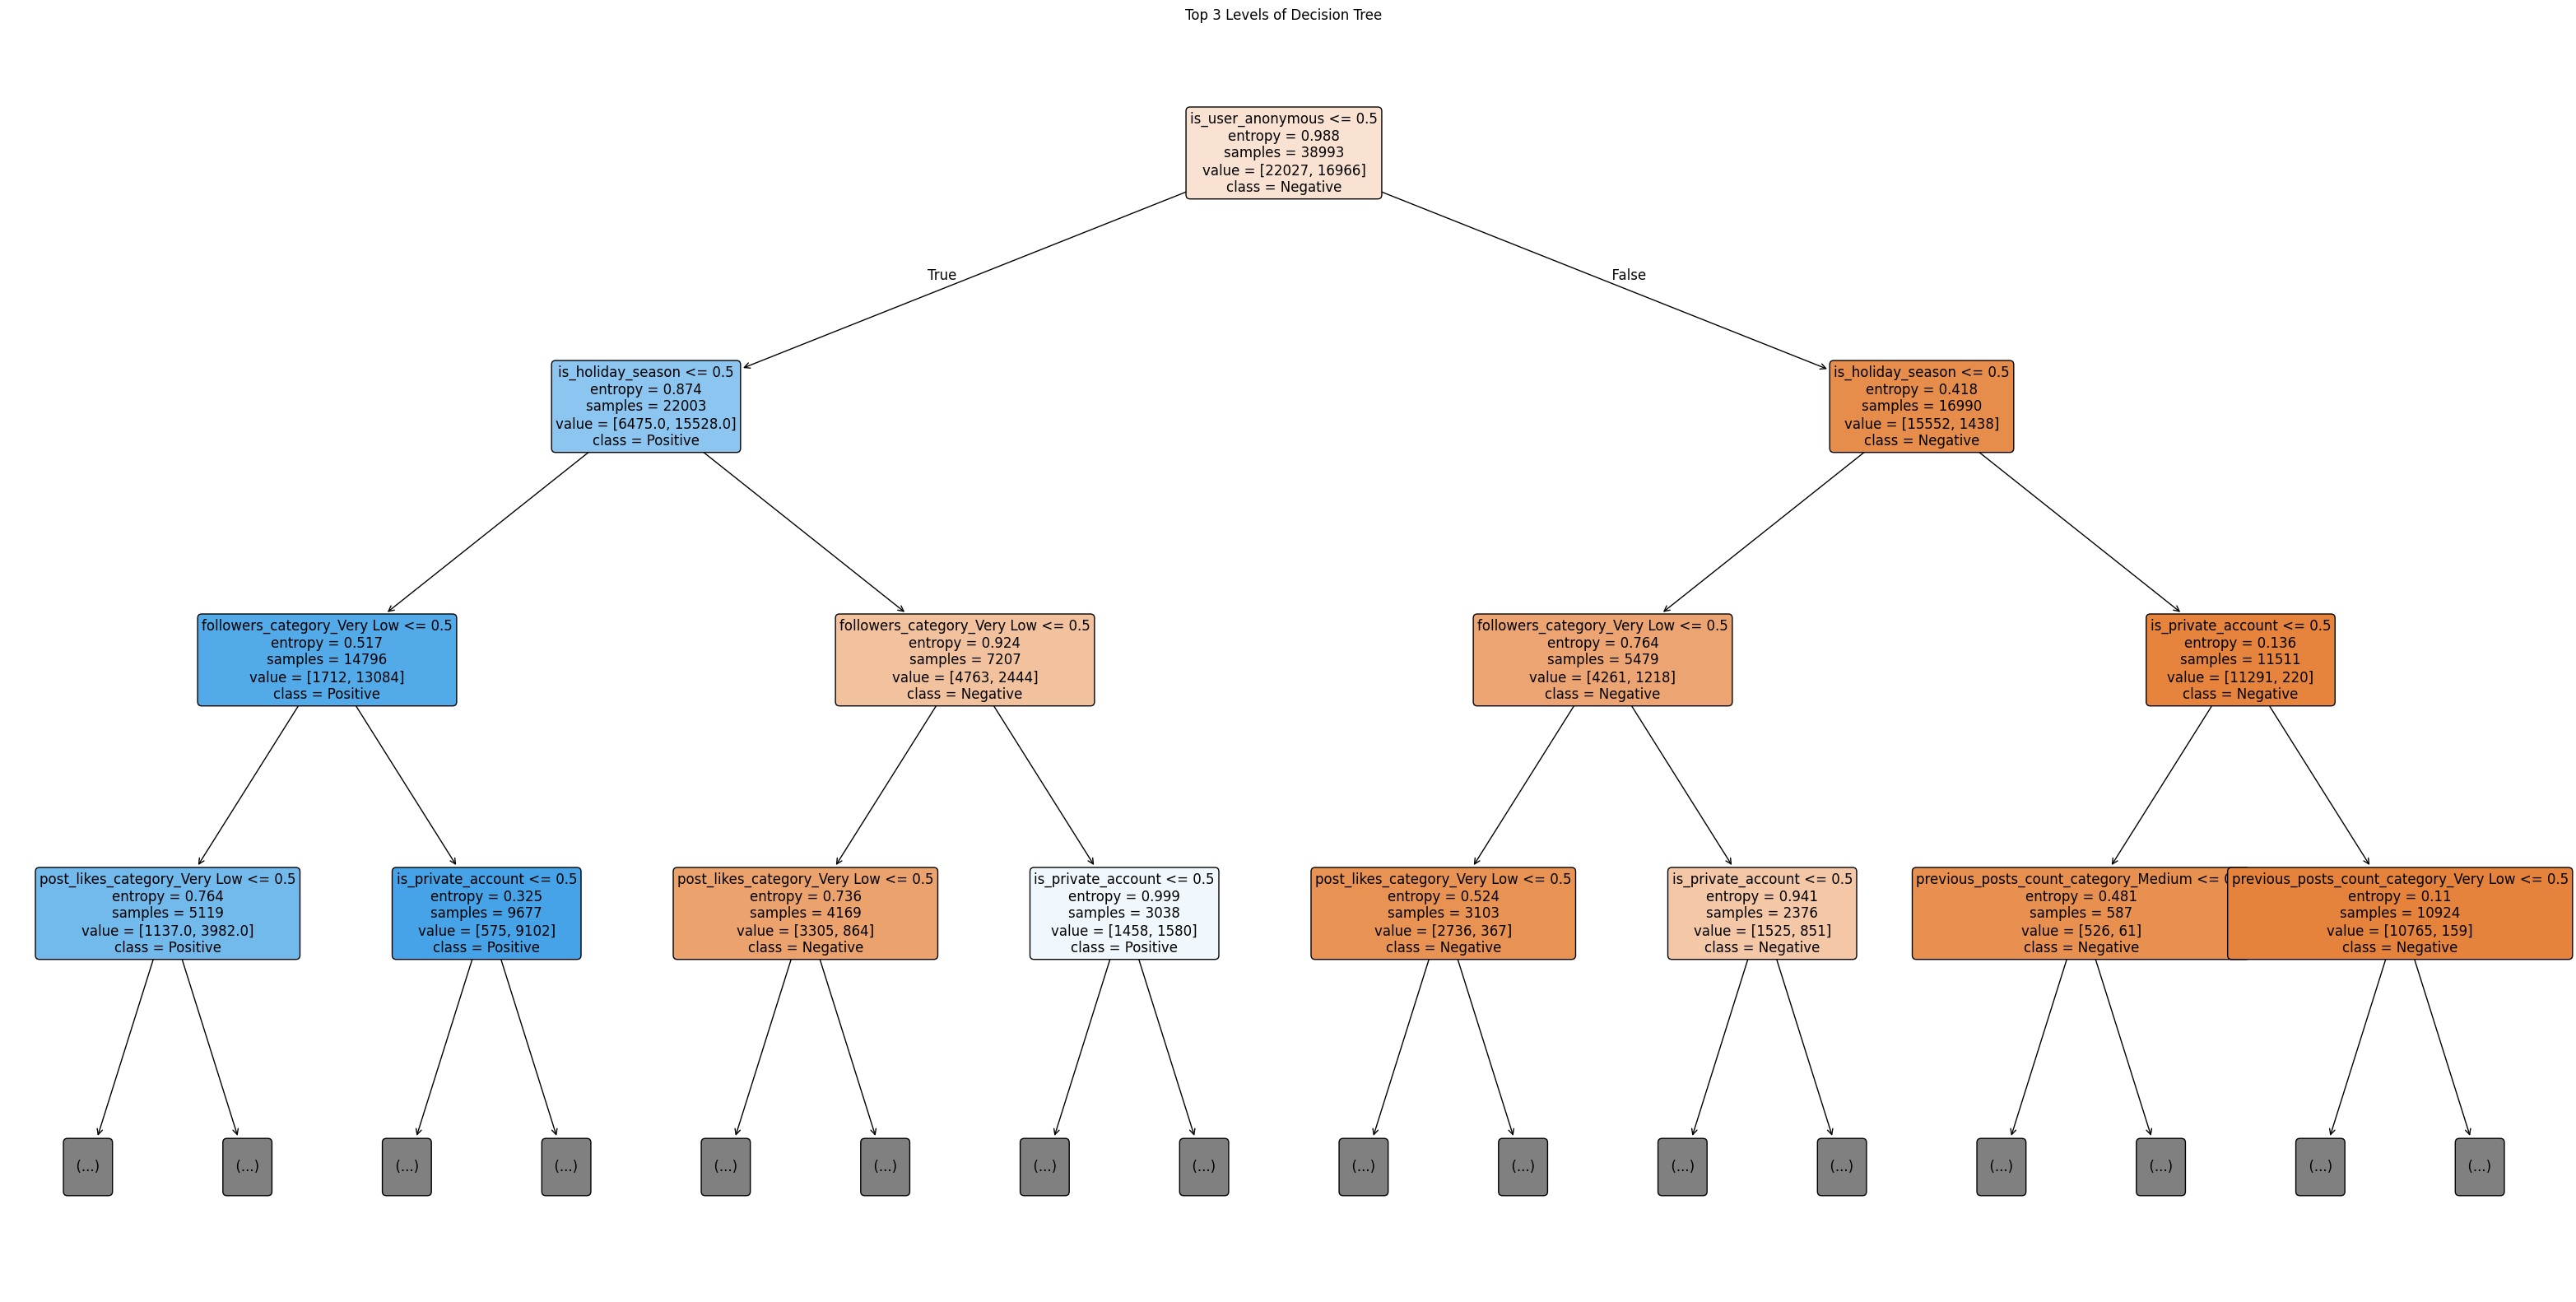

In [ ]:

tree_model = best_model_dt.named_steps['model']

output_feature_names = preprocessor_fitted.get_feature_names_out()
clean_feature_names = [name.split('__')[-1] for name in output_feature_names]
output_feature_names = clean_feature_names
# plot
plt.figure(figsize=(40, 20))
plot_tree(
    tree_model,
    feature_names=output_feature_names,
    class_names=['Negative', 'Positive'],
    filled=True,
    max_depth=3,
    fontsize=12,
    rounded=True,
    impurity=True
)
plt.title("Top 3 Levels of Decision Tree")
plt.show()



### Selection of the Top Features by Importance in the Final Model

After training the final Decision Tree model, the importance of each of the top 25 features is extracted using the model's built-in feature importance scores.  This helps identify the most influential features in the classification task.

✅ Feature Importances:
                                    Feature  Importance
3                        is_user_anonymous    0.477035
4                        is_holiday_season    0.245904
24            post_likes_category_Very Low    0.064860
5              followers_category_Very Low    0.058867
6                       is_private_account    0.042171
9   previous_posts_count_category_Very Low    0.025157
10    previous_posts_count_category_Medium    0.023710
15         text_length_category_Very Short    0.010068
22              text_length_category_Short    0.008644
16                     has_profile_picture    0.008478
21              post_hour_category_Morning    0.006411
19              post_hour_category_Evening    0.006246
20             text_length_category_Medium    0.004904
18               text_length_category_Long    0.003607
17                    user_age_group_adult    0.003330
8                   followers_category_Low    0.002437
7         posts_retweets_category_Very Lo

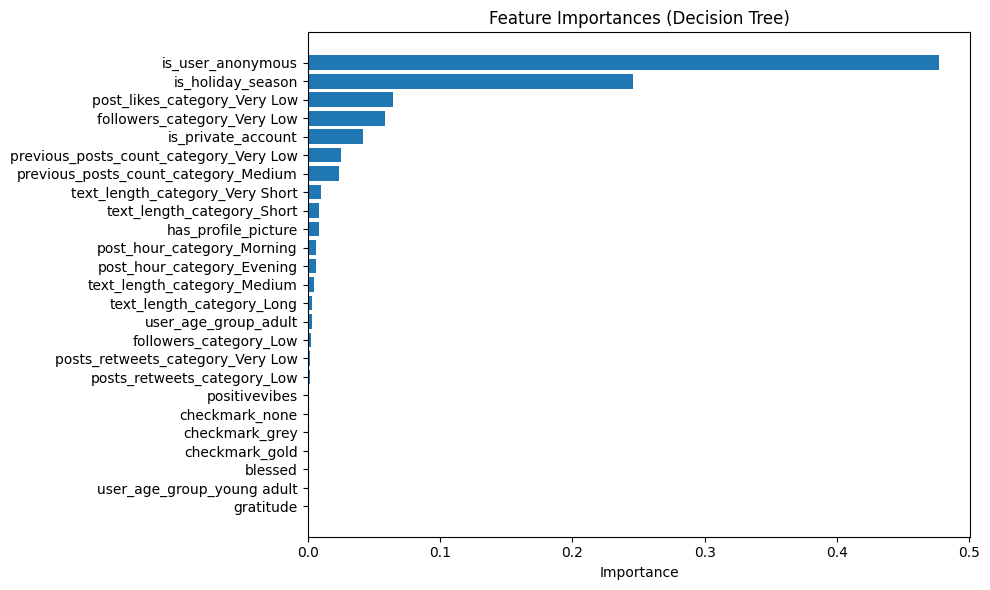

In [ ]:
# Top features from DT
tree_model_dt = best_model_dt.named_steps['model']

importances = tree_model_dt.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': clean_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("✅ Feature Importances:\n", feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.title("Feature Importances (Decision Tree)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## ANN 🧠

### Default Hyperparameters
The Artificial Neural Network (ANN) model used here is a Multi-Layer Perceptron (MLP) implemented with scikit-learn's MLPClassifier using default parameters. The network consists of an input layer with 25 neurons (one for each feature), a single hidden layer with 100 neurons, and an output layer that adjusts automatically based on the number of target classes. Each neuron in the hidden layer applies a weighted sum of inputs followed by a non-linear activation function (ReLU by default). This structure allows the model to learn complex patterns in the data even with a relatively simple architecture.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
# pipline settings
pipeline_ann_diff = Pipeline([
    ('preprocess', preprocessor),
    ('model', MLPClassifier(random_state=120))
])

results = cross_validate(
    pipeline_ann_diff,
    X_raw_final,
    y_target,
    cv=cv,
    scoring='roc_auc',
    return_train_score=True,
    n_jobs=-1
)

# reasults
print("ROC-AUC on Training Set per Fold:")
print("---------------------------------")
for i, score in enumerate(results['train_score']):
    print(f"Fold {i+1}: {score:.4f}")
print("\nROC-AUC on Validation Set per Fold:")
print("------------------------------------")
for i, score in enumerate(results['test_score']):
    print(f"Fold {i+1}: {score:.4f}")
print("\nSummary:")
print("--------")
print(f"Mean ROC-AUC on Training Set:   {results['train_score'].mean():.4f}")
print(f"Mean ROC-AUC on Validation Set: {results['test_score'].mean():.4f}")


ROC-AUC on Training Set per Fold:
---------------------------------
Fold 1: 0.9708
Fold 2: 0.9700
Fold 3: 0.9698
Fold 4: 0.9701
Fold 5: 0.9694
Fold 6: 0.9692
Fold 7: 0.9698
Fold 8: 0.9703
Fold 9: 0.9697
Fold 10: 0.9707

ROC-AUC on Validation Set per Fold:
------------------------------------
Fold 1: 0.9646
Fold 2: 0.9679
Fold 3: 0.9649
Fold 4: 0.9656
Fold 5: 0.9638
Fold 6: 0.9680
Fold 7: 0.9624
Fold 8: 0.9632
Fold 9: 0.9644
Fold 10: 0.9637

Summary:
--------
Mean ROC-AUC on Training Set:   0.9700
Mean ROC-AUC on Validation Set: 0.9648


### Hyperparameters Searched
- **hidden_layer_sizes**: Defines the architecture of the neural network. Options include one, two, or three hidden layers with 100 neurons each.
- **activation**: Activation function used in the hidden layers (`relu`, `tanh`, `logistic`).
- **learning_rate**: Set to `'adaptive'` – the learning rate is kept constant unless the model stops improving.
- **learning_rate_init**: Initial learning rate used in weight updates. Tested values include 0.001 to 0.05.
- **batch_size**: Size of mini-batches for training. Options include 128, 256, and 512.
- **early_stopping**: Enables early stopping to prevent overfitting based on validation loss.

The model is optimized using **RandomizedSearchCV** over 50 iterations with **ROC-AUC** as the evaluation metric and stratified 10-fold cross-validation.

In [ ]:
from sklearn.neural_network import MLPClassifier


pipeline_ann = Pipeline([
    ('preprocess', preprocessor),
    ('model', MLPClassifier(solver='sgd', max_iter=100, random_state=120))
])

# hyperparameter for random search
param_dist = {
    'model__hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
    'model__activation': ['relu', 'tanh', 'logistic'],
    'model__learning_rate': ['adaptive'],
    'model__learning_rate_init': [0.001, 0.005, 0.01, 0.05],
    'model__batch_size': [128, 256, 512],
    'model__early_stopping': [True]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline_ann,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=120,
    verbose=2,
    return_train_score=True
)

random_search.fit(X_raw_final, y_target)

# prints results
print("="*50)
print("Best Hyperparameters Found:")
print("="*50)
for param, value in random_search.best_params_.items():
    print(f"- {param}: {value}")
print("\nBest Mean ROC-AUC Score (Cross-Validation):")
print(f"{random_search.best_score_:.4f}")
print("="*50)
results_df = pd.DataFrame(random_search.cv_results_)
summary_table = results_df[[
    'mean_train_score',
    'mean_test_score',
    'params'
]].rename(columns={
    'mean_train_score': 'Train ROC-AUC',
    'mean_test_score': 'Validation ROC-AUC',
    'params': 'Hyperparameters'
})
summary_table = summary_table.sort_values(by='Validation ROC-AUC', ascending=False).reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
display(summary_table)



Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Hyperparameters Found:
- model__learning_rate_init: 0.05
- model__learning_rate: adaptive
- model__hidden_layer_sizes: (100, 100, 100)
- model__early_stopping: True
- model__batch_size: 512
- model__activation: tanh

Best Mean ROC-AUC Score (Cross-Validation):
0.9656


,Train ROC-AUC,Validation ROC-AUC,Hyperparameters
0,0.966654,0.965581,"{'model__learning_rate_init': 0.05, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (100, 100, 100), 'model__early_stopping': True, 'model__batch_size': 512, 'model__activation': 'tanh'}"
1,0.966184,0.965527,"{'model__learning_rate_init': 0.01, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (100, 100), 'model__early_stopping': True, 'model__batch_size': 128, 'model__activation': 'tanh'}"
2,0.967347,0.965469,"{'model__learning_rate_init': 0.05, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (100, 100), 'model__early_stopping': True, 'model__batch_size': 512, 'model__activation': 'relu'}"
3,0.966459,0.965416,"{'model__learning_rate_init': 0.05, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (100, 100), 'model__early_stopping': True, 'model__batch_size': 256, 'model__activation': 'tanh'}"
4,0.966614,0.965397,"{'model__learning_rate_init': 0.05, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (100, 100, 100), 'model__early_stopping': True, 'model__batch_size': 256, 'model__activation': 'tanh'}"
5,0.966226,0.965394,"{'model__learning_rate_init': 0.01, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (100, 100, 100), 'model__early_stopping': True, 'model__batch_size': 128, 'model__activation': 'tanh'}"
6,0.966096,0.965354,"{'model__learning_rate_init': 0.05, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (100,), 'model__early_stopping': True, 'model__batch_size': 256, 'model__activation': 'tanh'}"
7,0.966316,0.965327,"{'model__learning_rate_init': 0.05, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (100, 100), 'model__early_stopping': True, 'model__batch_size': 512, 'model__activation': 'tanh'}"
8,0.967146,0.965312,"{'model__learning_rate_init': 0.01, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (100, 100, 100), 'model__early_stopping': True, 'model__batch_size': 256, 'model__activation': 'relu'}"
9,0.967318,0.965259,"{'model__learning_rate_init': 0.05, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (100,), 'model__early_stopping': True, 'model__batch_size': 128, 'model__activation': 'relu'}"


In [ ]:
# best configuration
best_idx = random_search.best_index_

# mean AUC ROC
mean_train_score = random_search.cv_results_['mean_train_score'][best_idx]
mean_validation_score = random_search.cv_results_['mean_test_score'][best_idx]

# prints results
print("\n=== Summary ===")
print("----------------")
print(f"Best Mean ROC-AUC on Training Set:   {mean_train_score:.4f}")
print(f"Best Mean ROC-AUC on Validation Set: {mean_validation_score:.4f}")
print("----------------")


=== Summary ===
----------------
Best Mean ROC-AUC on Training Set:   0.9667
Best Mean ROC-AUC on Validation Set: 0.9656
----------------


### MLP Training Performance over Epochs

The plots visualize the model's learning process over 100 epochs using the best hyperparameters found by `RandomizedSearchCV`.

- **Left (ROC-AUC):** The ROC-AUC score improves on both train and validation sets in the early stages, with the validation curve peaking around epoch 40–50, then slightly declining — suggesting potential overfitting.
- **Right (Log Loss):** Both training and validation losses decrease initially, but validation loss starts increasing again after epoch ~60, reinforcing signs of overfitting.

These curves help identify the optimal number of training epochs and support the use of early stopping to prevent performance degradation.

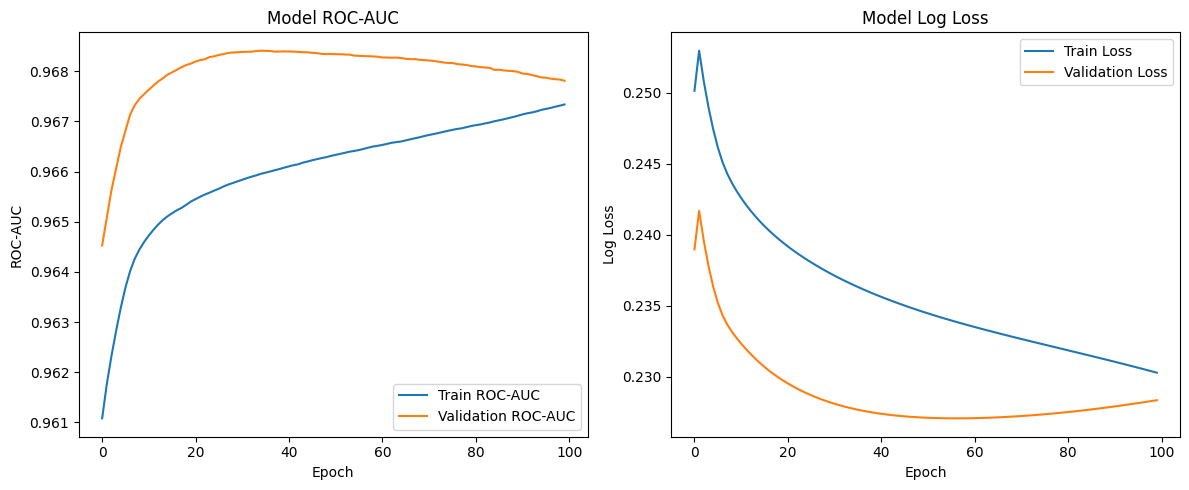

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)
X_train, X_val, y_train, y_val = train_test_split(
    X_raw_final, y_target, test_size=0.2, random_state=42, stratify=y_target
)

# best hyper parameter for RandomizedSearchCV
best_params = random_search.best_params_
pipeline_ann = Pipeline([
    ('preprocess', preprocessor),
    ('model', MLPClassifier(
        solver='sgd',
        max_iter=1,
        warm_start=True,
        random_state=120,
        **{k.replace('model__', ''): v for k, v in best_params.items()}
    ))
])

train_auc_list, val_auc_list = [], []
train_loss_list, val_loss_list = [], []

n_epochs = 100
for epoch in range(n_epochs):
    pipeline_ann.fit(X_train, y_train)

    train_proba = pipeline_ann.predict_proba(X_train)[:, 1]
    val_proba = pipeline_ann.predict_proba(X_val)[:, 1]

    train_auc = roc_auc_score(y_train, train_proba)
    val_auc = roc_auc_score(y_val, val_proba)

    train_loss = log_loss(y_train, train_proba)
    val_loss = log_loss(y_val, val_proba)

    train_auc_list.append(train_auc)
    val_auc_list.append(val_auc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

# plot
plt.figure(figsize=(12, 5))

# ROC-AUC
plt.subplot(1, 2, 1)
plt.plot(train_auc_list, label='Train ROC-AUC')
plt.plot(val_auc_list, label='Validation ROC-AUC')
plt.title('Model ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Model Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.tight_layout()
plt.show()


## SVM ↔️

### Linear SVM Classification

This code trains and tunes a **Linear Support Vector Machine (LinearSVC)** for binary sentiment classification.

- **C**: Regularization parameter controlling the trade-off between maximizing the margin and minimizing classification error.  
  - Lower values `-3` create a simpler model that tolerates more classification errors.  
  - Higher values `7` reduce training errors but risk overfitting.

- **class_weight**: Handles class imbalance.  
  - `balanced` automatically adjusts weights inversely proportional to class frequencies, which is useful when one class is underrepresented.

- **dual**: Whether to solve the dual or primal optimization problem.  
  - `True` is recommended when the number of features > number of samples.  
  - `False` is typically faster when samples > features (common with text data after feature selection).

These parameters significantly impact model performance and generalization, especially in imbalanced or high-dimensional datasets.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib

pipeline_svm = Pipeline([
    ('preprocess', preprocessor),
    ('model', LinearSVC(max_iter=3000, random_state=120))
])

# hyperparameter
param_dist_svm = {
    'model__C': np.logspace(-3, 3, 7),
    'model__class_weight': [None, 'balanced'],
    'model__dual': [True, False]
}

# RandomizedSearchCV
random_search_svm = RandomizedSearchCV(
    estimator=pipeline_svm,
    param_distributions=param_dist_svm,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=120
)

random_search_svm.fit(X_raw_final, y_target)
best_pipeline_svm = random_search_svm.best_estimator_
best_model_svm = best_pipeline_svm.named_steps['model']
preprocessor_fitted = best_pipeline_svm.named_steps['preprocess']
output_feature_names = preprocessor_fitted.get_feature_names_out()
clean_feature_names = [name.split('__')[-1] for name in output_feature_names]
pipeline_svm_calibrated = Pipeline([
    ('preprocess', preprocessor),
    ('model', CalibratedClassifierCV(best_model_svm, cv=5))
])

pipeline_svm_calibrated.fit(X_raw_final, y_target)
y_train_pred = pipeline_svm_calibrated.predict(X_raw_final)
train_accuracy = accuracy_score(y_target, y_train_pred)

val_accuracy_scores = cross_val_score(
    pipeline_svm_calibrated, X_raw_final, y_target, cv=cv, scoring='accuracy'
)
val_accuracy = val_accuracy_scores.mean()

# ROC AUC
y_train_proba = pipeline_svm_calibrated.predict_proba(X_raw_final)[:, 1]
train_roc_auc = roc_auc_score(y_target, y_train_proba)

# prints reasults
print("\n=== תוצאות SVM ===")
print("Best ROC-AUC Score - Validation:", round(random_search_svm.best_score_, 4))
print("Best ROC-AUC Score - Train:", round(train_roc_auc, 4))
print("Training Accuracy:", round(train_accuracy * 100, 2), "%")
print("Validation Accuracy (CV mean):", round(val_accuracy * 100, 2), "%")
print("Best Parameters:", random_search_svm.best_params_)

coefs = best_model_svm.coef_.flatten()
intercept = best_model_svm.intercept_[0]
print("\n=== משוואת ההחלטה ===")
print(f"f(x) = w^T x + b\nb = {round(intercept, 4)}")
for name, coef in zip(clean_feature_names, coefs):
    print(f"{name}: {round(coef, 4)}")

joblib.dump(pipeline_svm_calibrated, "best_linear_svm_model.pkl")

Fitting 10 folds for each of 20 candidates, totalling 200 fits

=== תוצאות SVM ===
Best ROC-AUC Score - Validation: 0.9635
Best ROC-AUC Score - Train: 0.9637
Training Accuracy: 90.1 %
Validation Accuracy (CV mean): 90.03 %
Best Parameters: {'model__dual': False, 'model__class_weight': 'balanced', 'model__C': np.float64(100.0)}

=== משוואת ההחלטה ===
f(x) = w^T x + b
b = 0.2095
positivevibes: 1.9843
gratitude: 1.7412
blessed: 2.3438
is_user_anonymous: -1.0782
is_holiday_season: -0.853
followers_category_Very Low: 0.5748
is_private_account: -0.3214
posts_retweets_category_Very Low: 0.3298
followers_category_Low: 0.0377
previous_posts_count_category_Very Low: -0.3194
previous_posts_count_category_Medium: 0.2725
posts_retweets_category_Low: 0.163
checkmark_gold: 0.2361
checkmark_grey: 0.2948
checkmark_none: -0.0124
text_length_category_Very Short: -0.2229
has_profile_picture: 0.147
user_age_group_adult: 0.3731
text_length_category_Long: 0.3137
post_hour_category_Evening: -0.1618
text_lengt

['best_linear_svm_model.pkl']

## Clustering 🍇

In [ ]:
!pip install gower
!pip install pyclustering

  Using cached gower-0.1.2-py3-none-any.whl.metadata (3.7 kB)
Using cached gower-0.1.2-py3-none-any.whl (5.2 kB)
     ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
     ---- ----------------------------------- 0.3/2.6 MB ? eta -:--:--
     ---------------------------------------- 2.6/2.6 MB 11.6 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395230 sha256=ba9c5477fa7dde7e7a4dee30c1be659cf40444db14e55bc4d9e361fcac051767
  Stored in directory: c:\users\mouki\appdata\local\pip\cache\wheels\82\ff\9c\fb3aedfa7966808cbd411ebca7df35bf731fe9e01c2cd699ee
Successfully built pyclustering


### K-Medoids Clustering with Gower Distance

We used **K-Medoids** clustering on a sample of 4,000 records using a **Gower distance matrix**, which supports mixed data types.

- Clustering is run for K values from 2 to 8.
- For each K, two internal metrics are calculated:
  - **Silhouette Score** (higher = better separation)
  - **Davies-Bouldin Index** (lower = better compactness)
- Results help determine the optimal number of clusters based on structure in the data.

Labels for K=2 are saved for visualization.


In [ ]:
import gower
from tqdm import tqdm
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Randomly sampling 4000 samples from the dataset for reasenable runtime
df_sample = features_set.sample(n=4000, random_state=120).reset_index(drop=True)

#taking care of boolean deffined columns
for col in df_sample.columns:
    if str(df_sample[col].dtype) == 'boolean' or str(df_sample[col].dtype) == 'bool':
        df_sample[col] = df_sample[col].astype(int)
#primting for process indication while running
print("📌 צורת הדגימה:", df_sample.shape)
print("⚙️ מחשב מטריצת Gower...")
gower_dist_matrix = gower.gower_matrix(df_sample)
print("✅ מטריצת Gower מוכנה! צורה:", gower_dist_matrix.shape)

sil_list = []
dbi_list = []

all_labels = None


for n_clusters in tqdm(range(2, 9)):
    print(f"\n🔍 מריץ K={n_clusters}")

    initial_medoids = np.random.choice(len(df_sample), n_clusters, replace=False).tolist()
    kmedoids_instance = kmedoids(
        gower_dist_matrix, initial_medoids, data_type='distance_matrix', ccore=False
    )

    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()

    labels = np.zeros(len(df_sample))
    for cluster_id, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_id

    sil_score = silhouette_score(gower_dist_matrix, labels, metric="precomputed")
    db_score = davies_bouldin_score(df_sample, labels)

    sil_list.append(sil_score)
    dbi_list.append(db_score)

    print(f"   ✅ Silhouette: {sil_score:.4f}, Davies-Bouldin: {db_score:.4f}")

    # saving the lables for plotting afterwards
    if n_clusters == 2:
        all_labels = labels


results_df = pd.DataFrame({
    'K': list(range(2, 9)),
    'Silhouette': sil_list,
    'Davies-Bouldin': dbi_list
})

print("\n📊 תוצאות סופיות:")
print(results_df)

📌 צורת הדגימה: (4000, 25)
⚙️ מחשב מטריצת Gower...
✅ מטריצת Gower מוכנה! צורה: (4000, 4000)


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]


🔍 מריץ K=2


 14%|████████████                                                                        | 1/7 [00:30<03:02, 30.47s/it]

   ✅ Silhouette: 0.3134, Davies-Bouldin: 2.0225

🔍 מריץ K=3


 29%|████████████████████████                                                            | 2/7 [01:29<03:56, 47.35s/it]

   ✅ Silhouette: 0.2385, Davies-Bouldin: 2.6232

🔍 מריץ K=4


 43%|████████████████████████████████████                                                | 3/7 [03:56<06:11, 92.88s/it]

   ✅ Silhouette: 0.1651, Davies-Bouldin: 2.9008

🔍 מריץ K=5


 57%|███████████████████████████████████████████████▍                                   | 4/7 [06:35<05:56, 118.79s/it]

   ✅ Silhouette: 0.1628, Davies-Bouldin: 2.8175

🔍 מריץ K=6


 71%|███████████████████████████████████████████████████████████▎                       | 5/7 [11:07<05:48, 174.30s/it]

   ✅ Silhouette: 0.1448, Davies-Bouldin: 2.8289

🔍 מריץ K=7


 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [16:43<03:49, 229.20s/it]

   ✅ Silhouette: 0.1601, Davies-Bouldin: 2.5444

🔍 מריץ K=8


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [23:05<00:00, 197.95s/it]

   ✅ Silhouette: 0.1838, Davies-Bouldin: 2.4330

📊 תוצאות סופיות:
   K  Silhouette  Davies-Bouldin
0  2    0.313431        2.022529
1  3    0.238467        2.623180
2  4    0.165062        2.900808
3  5    0.162799        2.817525
4  6    0.144811        2.828900
5  7    0.160150        2.544409
6  8    0.183751        2.433016


### K-Medoids Clusters Visualization  by PCA

The scatter plot shows the results of **K-Medoids clustering** (with K=2) after reducing the dataset to two principal components using **PCA** for visualization.

- Each point represents a data sample, colored by its assigned cluster.
- The clear separation between the two clusters indicates a meaningful structure in the data.
- This supports the internal evaluation metrics (high Silhouette, low Davies-Bouldin) and suggests K=2 is a reasonable choice.


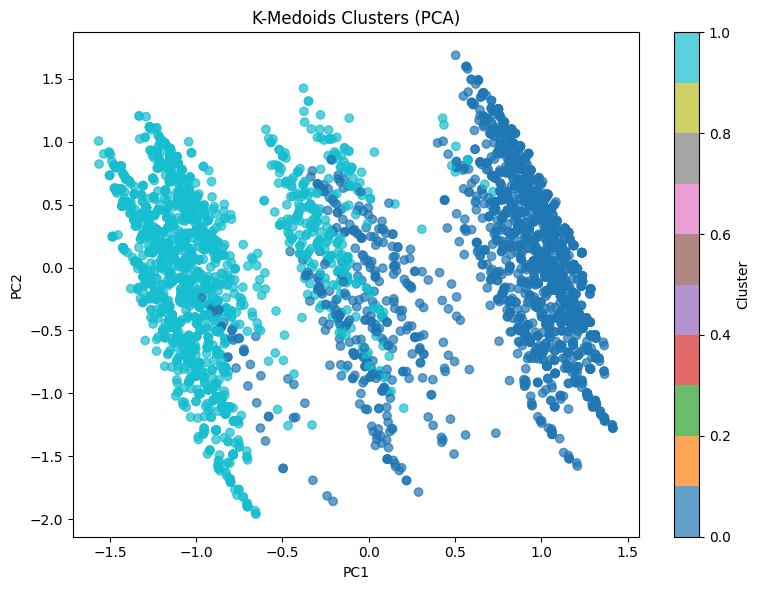

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

#pca down to 2 compomemts for 2D visualisation
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_sample)


df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['Cluster'] = all_labels


plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df_pca['PC1'], df_pca['PC2'],
    c=df_pca['Cluster'],
    cmap='tab10',
    alpha=0.7
)
plt.title('K-Medoids Clusters (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')


cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.tight_layout()
plt.show()


## Evaluations 📈

### ROC Curve – Decision Tree vs. Naive Classifier
The ROC curve above compares the performance of our Decision Tree classifier (AUC = 0.958) to a naive baseline model (AUC = 0.500). The curve shows good separation between classes, indicating strong predictive performance.
The optimal threshold (marked in red) is approximately 0.42, selected using Youden's J statistic, which balances true positive and false positive rates.

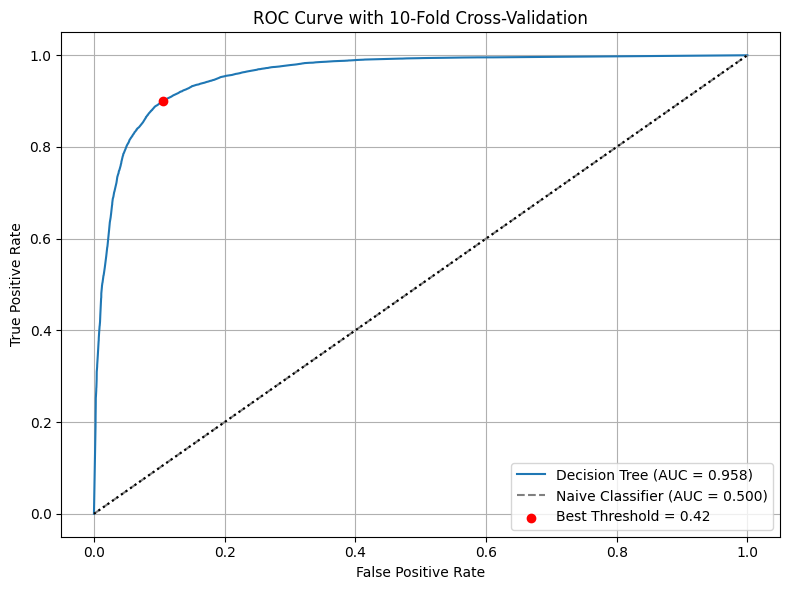

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.dummy import DummyClassifier

y_proba_cv = cross_val_predict(
    estimator=best_model_dt,
    X=X_raw_final,
    y=y_target,
    cv=cv,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# calculate Roc Auc
fpr, tpr, thresholds = roc_curve(y, y_proba_cv)
roc_auc = auc(fpr, tpr)

# Threshold by Youden's J
youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]

# Dummy Classifier
dummy = DummyClassifier(strategy="most_frequent")
y_dummy_proba = cross_val_predict(
    dummy, X[top_25_features], y, cv=cv, method="predict_proba"
)[:, 1]
fpr_dummy, tpr_dummy, _ = roc_curve(y, y_dummy_proba)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

# plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {roc_auc:.3f})")
plt.plot(fpr_dummy, tpr_dummy, linestyle='--', color='gray', label=f"Naive Classifier (AUC = {roc_auc_dummy:.3f})")
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f"Best Threshold = {best_threshold:.2f}", zorder=5)
plt.plot([0, 1], [0, 1], linestyle=':', color='black')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with 10-Fold Cross-Validation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Confusion Matrix and Performance Metrics (Threshold = 0.42)

The confusion matrix above displays the model's classification results on the full dataset using a decision threshold of **0.42**.
The results show that the model achieves **balanced performance** across both classes, with high recall and specificity, making it suitable for sentiment classification tasks.


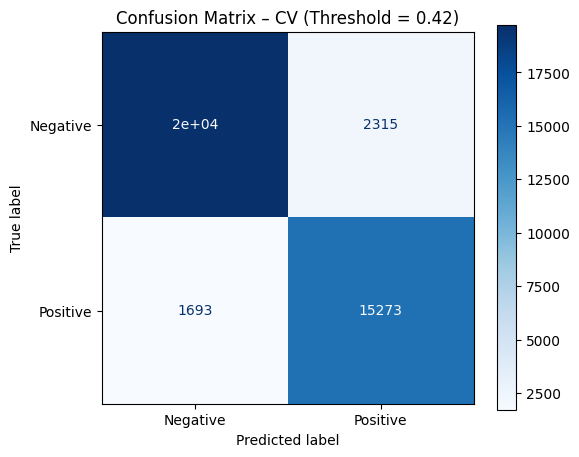

Accuracy     = 0.897   → (TP + TN) / total
Precision    = 0.868   → TP / (TP + FP)
Recall       = 0.900   → TP / (TP + FN)
Specificity  = 0.895   → TN / (TN + FP)
F1 Score     = 0.884


In [ ]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
y_pred_cv = (y_proba_cv >= best_threshold).astype(int)
cm = confusion_matrix(y_target, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])


fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax)
plt.title(f"Confusion Matrix – CV (Threshold = {best_threshold:.2f})")
plt.show()


TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

accuracy = accuracy_score(y_target, y_pred_cv)
precision = precision_score(y_target, y_pred_cv)
recall = recall_score(y_target, y_pred_cv)
specificity = TN / (TN + FP)
f1 = f1_score(y_target, y_pred_cv)


print(f"Accuracy     = {accuracy:.3f}   → (TP + TN) / total")
print(f"Precision    = {precision:.3f}   → TP / (TP + FP)")
print(f"Recall       = {recall:.3f}   → TP / (TP + FN)")
print(f"Specificity  = {specificity:.3f}   → TN / (TN + FP)")
print(f"F1 Score     = {f1:.3f}")


## Improvments 🚀


### Feature Selection Improvment
We improved the dataset by switching the feature selection method from **Fisher Score** to **Mutual Information**, which captures both linear and non-linear dependencies with the target. The top 25 features with the highest MI scores were selected to create a more informative feature set (`features_set_mi`).


In [ ]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI Score': mi_scores
}).sort_values(by='MI Score', ascending=False)

print("Mutual Information Scores:")
print(mi_df.head(25))
top_25_mi = mi_df.head(25)['Feature'].tolist()

print("\n Top 25 Features (MI):")
for feature in top_25_mi:
    print("-", feature)
features_set_mi = X[top_25_mi]

print("New Dataset", features_set_mi.shape)

Mutual Information Scores:
                                    Feature  MI Score
3                         is_user_anonymous  0.220269
2                         is_holiday_season  0.179817
20              followers_category_Very Low  0.063142
4                        is_private_account  0.055185
24         posts_retweets_category_Very Low  0.051207
16   previous_posts_count_category_Very Low  0.045795
21                   followers_category_Low  0.044435
18     previous_posts_count_category_Medium  0.042735
25              posts_retweets_category_Low  0.035373
10                           checkmark_grey  0.027046
9                            checkmark_gold  0.024653
11                           checkmark_none  0.023254
0                       has_profile_picture  0.015113
35               post_hour_category_Evening  0.012776
49          text_length_category_Very Short  0.012102
39                     user_age_group_adult  0.011018
47              text_length_category_Medium  0.010601
3

In [ ]:
# Range for the hyperparameters
param_dist = {
    'max_depth': [None, 5, 10, 15, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Model creation
dt_model = DecisionTreeClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist,
    n_iter=300,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(features_set_mi, y)
best_model = random_search.best_estimator_
y_train_proba = best_model.predict_proba(features_set_mi)[:, 1]
train_roc_auc = roc_auc_score(y, y_train_proba)

print("Best ROC-AUC Score - Validation:", round(random_search.best_score_, 4))
print("Best ROC-AUC Score - Train:", round(train_roc_auc, 4))
print("Best Parameters:", random_search.best_params_)
joblib.dump(best_model, "best_decision_tree_model_with_MI_features.pkl")
print("✅ נשמר כ: best_decision_tree_model_with_MI_features.pkl")


Fitting 10 folds for each of 300 candidates, totalling 3000 fits
Best ROC-AUC Score - Validation: 0.9578
Best ROC-AUC Score - Train: 0.9669
Best Parameters: {'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}
✅ נשמר כ: best_decision_tree_model_with_MI_features.pkl


### Improving Feature Representation: Categorical → Numeric

To enhance model performance, we transformed several categorical or date-based features into meaningful **numeric features**.  
This includes computing values like **user age**, **account age**, and **text length**, instead of using raw categorical inputs.

By converting features to a **continuous numeric form** and scaling them with `MinMaxScaler`, we enable the model to better capture variations in the data and improve its predictive power.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
#defining a dataset with numeric features instead of categorical

current_year = datetime.now().year

improv_data['age'] = current_year - improv_data['birthday'].dt.year
improv_data['account_age'] = current_year - improv_data['account_creation_year']
improv_data['text_length'] = improv_data['text'].astype(str).apply(len)


improv_data = categorize_post_hour(improv_data)
improv_data = categorize_age(improv_data)
improv_data = add_is_birthday(improv_data)
improv_data = add_is_holiday_season(improv_data)
improv_data = add_is_user_anonymous(improv_data)
improv_data = add_is_private_account(improv_data)


numeric_features = [
    'previous_posts_count',
    'followers',
    'posts_retweets',
    'post_likes',
    'age',
    'account_age',
    'text_length'
]

scaler = MinMaxScaler()
numeric_scaled = scaler.fit_transform(improv_data[numeric_features])
numeric_scaled_df = pd.DataFrame(numeric_scaled, columns=numeric_features)





Post Time Categories Mapping:
Category     |     Hours Range
------------------------------
Morning      | 05:00–10:59
Noon         | 11:00–13:59
Afternoon    | 14:00–17:59
Evening      | 18:00–22:59
Night        | 23:00–04:59

Age Categories Mapping:
Category     |  Age Range
----------------------------
child        | 0–12
teenager     | 13–17
young adult  | 18–24
adult        | 25+


In [ ]:
import pandas as pd

other_columns =['text', 'sentiment', 'has_profile_picture', 'is_birthday',
       'is_holiday_season', 'is_user_anonymous', 'is_private_account',
       'type_post', 'type_reply', 'type_retweet', 'checkmark_blue',
       'checkmark_gold', 'checkmark_grey', 'checkmark_none',
       'embedded_category_image', 'embedded_category_link',
       'embedded_category_missing', 'embedded_category_video', 'post_hour_category_Afternoon',
       'post_hour_category_Evening', 'post_hour_category_Morning',
       'post_hour_category_Night', 'post_hour_category_Noon',]



existing_columns = [col for col in other_columns if col in new_data.columns]


other_data = new_data[existing_columns]


final_data_improv = pd.concat([numeric_scaled_df, other_data], axis=1)

print("✅ Final dataset shape:", final_data_improv.shape)
print(final_data_improv.columns)


✅ Final dataset shape: (39981, 30)
Index(['previous_posts_count', 'followers', 'posts_retweets', 'post_likes',
       'age', 'account_age', 'text_length', 'text', 'sentiment',
       'has_profile_picture', 'is_birthday', 'is_holiday_season',
       'is_user_anonymous', 'is_private_account', 'type_post', 'type_reply',
       'type_retweet', 'checkmark_blue', 'checkmark_gold', 'checkmark_grey',
       'checkmark_none', 'embedded_category_image', 'embedded_category_link',
       'embedded_category_missing', 'embedded_category_video',
       'post_hour_category_Afternoon', 'post_hour_category_Evening',
       'post_hour_category_Morning', 'post_hour_category_Night',
       'post_hour_category_Noon'],
      dtype='object')


In [ ]:
final_data_improv = final_data_improv[~final_data_improv['sentiment'].isnull()].copy()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

#the same Ngram extraction for the new dataset
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.5,
    ngram_range=(1, 2),
    stop_words='english',
    token_pattern=r'\b[^\d\W]+\b'
)

X_text = final_data_improv['text'].astype(str)


X_tfidf = tfidf_vectorizer.fit_transform(X_text)

feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_tfidf.toarray()
feature_tfidf_df = pd.DataFrame(data=tfidf_scores, columns=feature_names, index=final_data_improv.index)


avg_scores = np.mean(tfidf_scores, axis=0)
scores_df = pd.DataFrame({'Feature': feature_names, 'AvgScore': avg_scores})

sorted_scores_df = scores_df.sort_values(by='AvgScore', ascending=False).head(100)
top_features = sorted_scores_df['Feature'].values
feature_tfidf_df = feature_tfidf_df[top_features]


scaler = MinMaxScaler()
feature_tfidf_df_scaled = pd.DataFrame(
    scaler.fit_transform(feature_tfidf_df),
    columns=feature_tfidf_df.columns,
    index=feature_tfidf_df.index
)

#checkups for matrix cordination
print("🔍 final_data_improv shape:", final_data_improv.drop(columns=['text']).shape)
print("🔍 TF-IDF scaled shape:", feature_tfidf_df_scaled.shape)

if final_data_improv.drop(columns=['text']).shape[0] != feature_tfidf_df_scaled.shape[0]:
    raise ValueError("⚠️ מספר השורות לא תואם! לא ניתן לחבר.")
else:
    print("✅ מספר השורות תואם! אפשר להמשיך לחיבור.")


final_data_improv_with_text = pd.concat(
    [final_data_improv.drop(columns=['text']), feature_tfidf_df_scaled],
    axis=1
)

print("✅ Number of added words:", len(top_features))
print("\nTop 100 words (after scaling):")
print(top_features)
print("\n✅ final_data_improv_with_text shape:", final_data_improv_with_text.shape)


🔍 final_data_improv shape: (38993, 29)
🔍 TF-IDF scaled shape: (38993, 100)
✅ מספר השורות תואם! אפשר להמשיך לחיבור.
✅ Number of added words: 100

Top 100 words (after scaling):
['feeling' 'like' 'im' 'feel like' 'just' 'im feeling' 'really' 't' 'know'
 'time' 'little' 'people' 'want' 'think' 'ive' 'life' 'bit' 'love'
 'things' 'dont' 'm' 'way' 's' 'make' 'don' 'mentalhealthawareness'
 'don t' 'going' 'day' 'pretty' 'right' 'need' 'feels' 'feelings' 'good'
 'today' 'did' 'say' 'work' 'just feel' 'help' 'didnt' 't feel' 'makes'
 'got' 'happy' 'quite' 'doing' 'selfcare' 'http' 'positivevibes' 'home'
 'left' 'feeling little' 'days' 'lot' 'having' 'href' 'friends' 'kind'
 'href http' 'person' 'sure' 'getting' 'look' 'actually' 'like im' 'felt'
 'blessed' 'better' 'said' 'started' 'come' 'feel little' 'thought' 'new'
 'sad' 'feel really' 'thing' 'world' 'long' 'remember' 'away'
 'feeling like' 'try' 'stressed' 'bad' 'angry' 'week' 'able' 'start'
 'gratitude' 'feeling bit' 'family' 'hurt' 'mom

In [ ]:
#feature selection - Fischer Score
def compute_feature_scores(X, y):
    scores = {}
    class_pos = X[y == 1]
    class_neg = X[y == 0]
    for column in X.columns:
        mean_pos = class_pos[column].mean()
        mean_neg = class_neg[column].mean()
        std_pos = class_pos[column].std()
        std_neg = class_neg[column].std()

        numerator = abs(mean_pos - mean_neg)
        denominator = std_pos + std_neg
        score = numerator / denominator if denominator != 0 else 0

        scores[column] = score

    scores_df = pd.DataFrame(list(scores.items()), columns=['Feature', 'Score'])
    scores_df = scores_df.sort_values(by='Score', ascending=False)

    return scores_df


X_improv = final_data_improv_with_text.drop('sentiment', axis=1)
y_improv = final_data_improv_with_text['sentiment']

feature_scores_improv = compute_feature_scores(X_improv, y_improv)

print(feature_scores_improv.head(50))

                        Feature     Score
10            is_user_anonymous  0.846308
9             is_holiday_season  0.707337
11           is_private_account  0.345752
16               checkmark_gold  0.229939
17               checkmark_grey  0.229109
18               checkmark_none  0.197721
7           has_profile_picture  0.153016
78                positivevibes  0.138305
24   post_hour_category_Evening  0.136887
25   post_hour_category_Morning  0.129822
119                   gratitude  0.119551
96                      blessed  0.109724
113                    stressed  0.090358
115                       angry  0.088806
28                      feeling  0.072717
76                     selfcare  0.071943
104                         sad  0.069594
122                        hurt  0.066345
114                         bad  0.064015
44                          bit  0.063603
45                         love  0.061573
15               checkmark_blue  0.061313
73                        happy  0

In [ ]:
top_25_features_improv = feature_scores_improv['Feature'].head(25).tolist()

features_set_improv = X_improv[top_25_features_improv]

print (features_set_improv.columns)

Index(['is_user_anonymous', 'is_holiday_season', 'is_private_account',
       'checkmark_gold', 'checkmark_grey', 'checkmark_none',
       'has_profile_picture', 'positivevibes', 'post_hour_category_Evening',
       'post_hour_category_Morning', 'gratitude', 'blessed', 'stressed',
       'angry', 'feeling', 'selfcare', 'sad', 'hurt', 'bad', 'bit', 'love',
       'checkmark_blue', 'happy', 'feeling bit', 'just feel'],
      dtype='object')


In [ ]:
print(y_improv.isnull().sum())

0


In [ ]:
# Range for the hyperparameters
param_dist = {
    'max_depth': [None, 5, 10, 15, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Model creation
dt_model = DecisionTreeClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist,
    n_iter=300,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_improv[top_25_features_improv], y_improv)
best_model = random_search.best_estimator_
y_train_proba = best_model.predict_proba(X_improv[top_25_features_improv])[:, 1]
train_roc_auc = roc_auc_score(y, y_train_proba)
print("Best ROC-AUC Score - Validation:", round(random_search.best_score_, 4))
print("Best ROC-AUC Score - Train:", round(train_roc_auc, 4))
print("Best Parameters:", random_search.best_params_)
joblib.dump(best_model, "best_decision_tree_model.pkl")


Fitting 10 folds for each of 300 candidates, totalling 3000 fits
Best ROC-AUC Score - Validation: 0.9328
Best ROC-AUC Score - Train: 0.9404
Best Parameters: {'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy'}


['best_decision_tree_model.pkl']

### From Decision Tree to Gradient Boosting

To improve performance over traditional decision trees, we trained a **Gradient Boosting Classifier**, which builds an ensemble of shallow trees sequentially—each correcting the errors of the previous one.

- We used `RandomizedSearchCV` to optimize key hyperparameters (e.g., learning rate, tree depth, number of estimators).
- The model was evaluated using **ROC-AUC** as the scoring metric.
- The final trained model (`best_gradient_boosting_model.pkl`) showed improved predictive performance compared to a single decision tree, leveraging the strength of boosting.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

''' this block if for training a gradient boosting model as improvment for our chosen model'''
X_gb_raw = X_raw_final
y_gb = y_target


pipeline_gb = Pipeline([
    ('preprocess', preprocessor),
    ('model', GradientBoostingClassifier(random_state=120))
])

param_dist_gb = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__max_depth': [3, 5, 7, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__max_features': ['sqrt', 'log2', None]
}


random_search_gb = RandomizedSearchCV(
    estimator=pipeline_gb,
    param_distributions=param_dist_gb,
    n_iter=50,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=120
)

random_search_gb.fit(X_gb_raw, y_gb)
best_pipeline_gb = random_search_gb.best_estimator_
y_train_proba = best_pipeline_gb.predict_proba(X_gb_raw)[:, 1]
train_roc_auc = roc_auc_score(y_gb, y_train_proba)
print("✅ Best ROC-AUC Score - Validation:", round(random_search_gb.best_score_, 4))
print("✅ Best ROC-AUC Score - Train:", round(train_roc_auc, 4))
print("✅ Best Parameters:", random_search_gb.best_params_)

joblib.dump(best_pipeline_gb, "best_gradient_boosting_model.pkl")


Fitting 10 folds for each of 50 candidates, totalling 500 fits
✅ Best ROC-AUC Score - Validation: 0.9657
✅ Best ROC-AUC Score - Train: 0.9689
✅ Best Parameters: {'model__subsample': 0.6, 'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': 5, 'model__learning_rate': 0.1}


['best_gradient_boosting_model.pkl']

# Test DataSet Creation ✅

The following code blocks handle the processing of the test data,
apply the selected model to classify the test set,
and generate the final post-santiment classification CSV file
for all test samples.

In [ ]:

from google.colab import files
uploaded = files.upload()

def convert_data_types_test(filtered_data):
    filtered_data['post_datetime'] = pd.to_datetime(filtered_data['post_datetime'], errors='coerce')
    filtered_data['account_creation_date'] = pd.to_datetime(filtered_data['account_creation_date'], errors='coerce')
    filtered_data['birthday'] = pd.to_datetime(filtered_data['birthday'], errors='coerce')
    filtered_data['post_likes'] = pd.to_numeric(filtered_data['post_likes'], errors='coerce')
    filtered_data['posts_retweets'] = pd.to_numeric(filtered_data['posts_retweets'], errors='coerce')
    filtered_data['followers'] = pd.to_numeric(filtered_data['followers'], errors='coerce')
    filtered_data['text'] = filtered_data['text'].astype('string')
    filtered_data['type'] = filtered_data['type'].astype('string')
    filtered_data['timezone'] = filtered_data['timezone'].astype('string')
    filtered_data['embedded_content_url'] = filtered_data['embedded_content_url'].astype('string')
    filtered_data['username'] = filtered_data['username'].astype('string')
    filtered_data['checkmark'] = filtered_data['checkmark'].astype('string')
    filtered_data['email'] = filtered_data['email'].astype('string')
    filtered_data['profile_picture'] = filtered_data['profile_picture'].astype('string')
    filtered_data['previous_posts_count'] = pd.to_numeric(filtered_data['previous_posts_count'], errors='coerce')

    return filtered_data

test_data = pd.read_csv('test.csv')
print("Number of rows in test_data:", test_data.shape[0])

test_data = remove_unnecessary_rows(test_data)
test_data = convert_data_types_test(test_data)

Number of rows in test_data: 10000

Percentage of rows with 8 question marks: 0.00%


In [ ]:
test_data =random_missing_values(test_data, 'timezone')
test_data =random_missing_values(test_data, 'post_datetime')
test_data = mean_missing_values(test_data, 'post_likes')
test_data = mean_missing_values(test_data, 'posts_retweets')

In [ ]:

test_data['embedded_category'] = test_data['embedded_content_url'].apply(classify_embedded)
test_data = test_data.drop('embedded_content_url', axis=1)
test_data['profile_picture'] = test_data['profile_picture'].notna().astype(int)
test_data = test_data.rename(columns={'profile_picture': 'has_profile_picture'})
test_data['account_creation_date'] = test_data['account_creation_date'].dt.year
test_data = test_data.rename(columns={'account_creation_date': 'account_creation_year'})

In [ ]:
test_data = categorize_previous_posts(test_data)
test_data = categorize_followers(test_data)
test_data = categorize_post_retweets(test_data)
test_data = categorize_post_likes(test_data)
test_data = categorize_post_hour(test_data)
test_data = categorize_age(test_data)
test_data = add_is_birthday(test_data)
test_data = add_is_holiday_season(test_data)
test_data = add_is_user_anonymous(test_data)
test_data = add_is_private_account(test_data)
test_data = add_account_age_category(test_data)
test_data = add_text_length_category(test_data)


Previous posts category Mapping:
Category   |    Range (inclusive)
-----------------------------------
Very Low   | 0–49
Low        | 50–149
Medium     | 150–299
High       | 300–679

Followers Category Mapping:
Category   |    Range (inclusive)
-----------------------------------
Very Low   | 0–99
Low        | 100–999
Medium     | 1000–9999
High       | 10000–120999

Post Retweets Category Mapping:
Category     |    Range (inclusive)
----------------------------------------
Very Low     | 0–9
Low          | 10–99
Medium       | 100–999
High         | 1000–4999
Very High    | 5000–16999

Post Likes Category Mapping:
Category     |    Range (inclusive)
----------------------------------------
Very Low     | 20–99
Low          | 100–999
Medium       | 1000–4999
High         | 5000–14999
Very High    | 15000–29999

Post Time Categories Mapping:
Category     |     Hours Range
------------------------------
Morning      | 05:00–10:59
Noon         | 11:00–13:59
Afternoon    | 14:00–17:59
Ev

In [ ]:
test_data = test_data.drop(
    [ 'post_datetime', 'timezone', 'post_likes', 'posts_retweets',
     'username', 'email', 'birthday', 'followers',
     'previous_posts_count', 'local_post_time', 'post_time_hour', 'age','account_creation_year','text_length'],
    axis=1
)

In [ ]:
def encode_binary_categories(df):
    columns_to_encode = [
        'type', 'checkmark', 'embedded_category', 'previous_posts_count_category',
        'followers_category', 'posts_retweets_category', 'post_likes_category',
        'post_hour_category', 'user_age_group', 'account_age_category', 'text_length_category']
    df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=False)

    return df_encoded

test_data = encode_binary_categories(test_data)


print(test_data.columns)

Index(['id', 'text', 'has_profile_picture', 'is_birthday', 'is_holiday_season',
       'is_user_anonymous', 'is_private_account', 'type_post', 'type_reply',
       'type_retweet', 'checkmark_blue', 'checkmark_gold', 'checkmark_grey',
       'checkmark_none', 'embedded_category_image', 'embedded_category_link',
       'embedded_category_missing', 'embedded_category_video',
       'previous_posts_count_category_Very Low',
       'previous_posts_count_category_Low',
       'previous_posts_count_category_Medium',
       'previous_posts_count_category_High', 'followers_category_Very Low',
       'followers_category_Low', 'followers_category_Medium',
       'followers_category_High', 'posts_retweets_category_Very Low',
       'posts_retweets_category_Low', 'posts_retweets_category_Medium',
       'posts_retweets_category_High', 'posts_retweets_category_Very High',
       'post_likes_category_Very Low', 'post_likes_category_Low',
       'post_likes_category_Medium', 'post_likes_category_High'

In [ ]:

X_text_test = test_data['text'].astype(str)


X_tfidf_test = tfidf_vectorizer.transform(X_text_test)


feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores_test = X_tfidf_test.toarray()
feature_tfidf_df_test = pd.DataFrame(data=tfidf_scores_test, columns=feature_names)
feature_tfidf_df_test.index = test_data.index


feature_tfidf_df_test = feature_tfidf_df_test[top_features]

ngram_features = [col for col in top_25_features if col in top_features]
binary_features = [col for col in top_25_features if col not in top_features]

X_ngram_unscaled_text = feature_tfidf_df_test[ngram_features].copy()


X_binary = test_data[binary_features].copy()




In [ ]:
X_test_raw = pd.concat([X_binary, X_ngram_unscaled_text], axis=1)
print(X_test_raw.columns)

Index(['is_user_anonymous', 'is_holiday_season', 'followers_category_Very Low',
       'is_private_account', 'posts_retweets_category_Very Low',
       'followers_category_Low', 'previous_posts_count_category_Very Low',
       'previous_posts_count_category_Medium', 'posts_retweets_category_Low',
       'checkmark_gold', 'checkmark_grey', 'checkmark_none',
       'text_length_category_Very Short', 'has_profile_picture',
       'user_age_group_adult', 'text_length_category_Long',
       'post_hour_category_Evening', 'text_length_category_Medium',
       'post_hour_category_Morning', 'text_length_category_Short',
       'user_age_group_young adult', 'post_likes_category_Very Low',
       'positivevibes', 'gratitude', 'blessed'],
      dtype='object')


In [ ]:

features_train = [
    'is_user_anonymous', 'is_holiday_season', 'followers_category_Very Low',
    'is_private_account', 'posts_retweets_category_Very Low',
    'followers_category_Low', 'previous_posts_count_category_Very Low',
    'previous_posts_count_category_Medium', 'posts_retweets_category_Low',
    'checkmark_gold', 'checkmark_grey', 'checkmark_none',
    'text_length_category_Very Short', 'has_profile_picture',
    'positivevibes', 'user_age_group_adult', 'text_length_category_Long',
    'post_hour_category_Evening', 'text_length_category_Medium',
    'post_hour_category_Morning', 'gratitude', 'text_length_category_Short',
    'user_age_group_young adult', 'blessed', 'post_likes_category_Very Low'
]

features_test = [
    'is_user_anonymous', 'is_holiday_season', 'followers_category_Very Low',
       'is_private_account', 'posts_retweets_category_Very Low',
       'followers_category_Low', 'previous_posts_count_category_Very Low',
       'previous_posts_count_category_Medium', 'posts_retweets_category_Low',
       'checkmark_gold', 'checkmark_grey', 'checkmark_none',
       'text_length_category_Very Short', 'has_profile_picture',
       'user_age_group_adult', 'text_length_category_Long',
       'post_hour_category_Evening', 'text_length_category_Medium',
       'post_hour_category_Morning', 'text_length_category_Short',
       'user_age_group_young adult', 'post_likes_category_Very Low',
       'positivevibes', 'gratitude', 'blessed']



train_set = set(features_train)
test_set = set(features_test)


missing_in_test = train_set - test_set
missing_in_train = test_set - train_set


if not missing_in_test and not missing_in_train:
    print("✅ הרשימות זהות לגמרי! אין הבדלים.")
else:
    if missing_in_test:
        print("❗ מופיעים ב-Train אבל חסרים ב-Test:")
        print(missing_in_test)
    if missing_in_train:
        print("❗ מופיעים ב-Test אבל חסרים ב-Train:")
        print(missing_in_train)


✅ הרשימות זהות לגמרי! אין הבדלים.


In [ ]:
print("Number of rows in test_data:",X_test_raw.shape[0])


Number of rows in test_data: 10000


In [ ]:



best_model = joblib.load("best_gradient_boosting_model.pkl")


y_pred = best_model.predict(X_test_raw)


output_labels = ['negative' if pred == 0 else 'positive' for pred in y_pred]


output_df = test_data[['id']].copy()
output_df['sentiment'] = output_labels


output_df.to_csv("group14.csv", index=False)
